# Model inference on open-source data

This notebook is a simple example of how to load a trained model and make predictions on a publicly available dataset. The model we're working with was trained using the scripts in notebook [4_backward_model_training.ipynb](4_backward_model_training.ipynb).

## Load data
For the purpose of inference we download a small open-source dataset unrelated with any data we've used so far. It is a [MACE](https://leopard.tu-braunschweig.de/receive/dbbs_mods_00076224) dataset with compounds not included in the NIST17 dataset. Some of them are in NIST20 though.

In [3]:
import sys
sys.path.append('..')

In [4]:
MACE_DIR = "../data/mace"
CHECKPOINT_DIR = "../../checkpoints/finetune/fearless-wildflower-490_rassp1_neims1_224kPretrain_148k/checkpoint-147476"
TOKENIZER_PATH = "../tokenizer/tokenizer_mf10M.model"

In [23]:
# download MACE data
! cd {MACE_DIR} && wget https://leopard.tu-braunschweig.de/servlets/MCRFileNodeServlet/dbbs_derivate_00054495/MACE_r05.mace

--2024-08-31 20:34:14--  https://leopard.tu-braunschweig.de/servlets/MCRFileNodeServlet/dbbs_derivate_00054495/MACE_r05.mace
Resolving leopard.tu-braunschweig.de (leopard.tu-braunschweig.de)... 193.174.240.199
Connecting to leopard.tu-braunschweig.de (leopard.tu-braunschweig.de)|193.174.240.199|:443... connected.
HTTP request sent, awaiting response... 200 200
Length: unspecified
Saving to: 'MACE_r05.mace.1'

MACE_r05.mace.1         [ <=>                ] 344.82K  --.-KB/s    in 0.09s   

2024-08-31 20:34:15 (3.82 MB/s) - 'MACE_r05.mace.1' saved [353094]



In [9]:
mace_path = f"{MACE_DIR}/MACE_r05.mace"

In [7]:
# the format of the MACE data is a bit inconsistent (because of the open-source nature), so we wrote our own .msp reader for this dataset 
import requests
import pandas as pd
from rich import progress
import re
from pathlib import Path

from utils.spectra_process_utils import remove_stereochemistry_and_canonicalize


def get_smiles_from_inchikey(inchikey):
    r = requests.get(f'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/inchikey/{inchikey}/property/CanonicalSMILES/JSON').json()    
    return r['PropertyTable']['Properties'][0]['CanonicalSMILES']

def parse_mz_intensity(f, num_peaks):
    mz = []
    intensity = []
    line = next(f)
    while line.strip() != "":
        line_peaks = [peak.strip().split(" ") for peak in re.split(";|:", line.strip())]
        for peak in line_peaks:
            if peak == ['']:
                continue
            peak = [peak_ for peak_ in peak if peak_ != '']
            mz_, intensity_ = peak
            mz.append(float(mz_))
            intensity.append(float(intensity_))
        try:
            line = next(f)
        except StopIteration:
            break
    if num_peaks != len(mz):
        num_peaks = len(mz)
    
    # sort peaks
    mz, intensity = zip(*sorted(zip(mz, intensity), key=lambda x: x[0]))

    return list(mz), list(intensity), num_peaks


def read_mace_msp(filename):
    """Iterate over MSP spectral library file and return spectra as dicts."""
    spectrum = {}
    mz = []
    intensity = []

    with progress.open(filename, "rt") as f:
        for line in f:
            # `Name: ` is the first line of a new entry in the file
            if line.startswith("Name: "):
                if spectrum:
                    # Finalize and yield previous spectrum
                    yield spectrum

                    # Define new spectrum
                    spectrum = {}
                    mz = []
                    intensity = []

                # Extract everything after `Name: `
                spectrum["Name"] = line.split(":")[1].strip()


            elif line.startswith("Comments: "):
                # Parse all comment items as metadata
                metadata_string = "".join(line.split(":")[1:]).strip()
                metadata = [i.split("=") for i in metadata_string.split(" ")]
                
                for item in metadata:
                    item = [i.strip() for i in item]
                    if item[0] == "Smiles":
                        spectrum["smiles"] = "".join(item[1:]) 
                    elif len(item) == 2:
                        spectrum[item[0]] = item[1]

            elif line.startswith("InChIKey: "):
                spectrum["InChIKey"] = line.split(":")[1].strip()
                
            elif line.startswith("Num Peaks:") or line.startswith("Num peaks:"):
                num_peaks = int(line.split(":")[1].strip())
                mz, intensity, num_peaks_  = parse_mz_intensity(f, num_peaks)   

                spectrum["num_peaks"] = num_peaks_
                spectrum["mz"] = mz
                spectrum["intensity"] = intensity 
                
    # Final spectrum
    yield spectrum

def remove_corrupted_spectra(spectra):
    clean_spectra = []
    for s in spectra:
        if not s.get("mz", False) or not s.get("intensity", False):
            continue
        
        s["smiles"] = remove_stereochemistry_and_canonicalize(s["smiles"])
        if not s.get("smiles", False) or not s["smiles"]:
            try:
                smi = get_smiles_from_inchikey(s["InChIKey"])
                s["smiles"] = remove_stereochemistry_and_canonicalize(smi)
                if not s["smiles"]:
                    continue
            except:
                continue
        clean_spectra.append(s) 
    return clean_spectra


def save_mace_jsonl(spectra, out_path):
    mzs = [s["mz"] for s in spectra]
    intensities = [s["intensity"] for s in spectra]
    canon_smiless = [s["smiles"] for s in spectra]
    df = pd.DataFrame({"mz": mzs, "intensity": intensities, "smiles": canon_smiless})
    df.to_json(out_path, orient="records", lines=True)

In [10]:
mace_jsonl_path = f"{Path(mace_path).with_suffix('.jsonl')}"

In [ ]:

spectra = list(read_mace_msp(mace_path))
clean_spectra = remove_corrupted_spectra(spectra)
save_mace_jsonl(clean_spectra, mace_jsonl_path)

print(f"Extracted: {len(clean_spectra)} spectra from MACE database")

## Generate predictions

Now we have the MACE dataset prepared the same way as all our NIST splits and can continue to predicting molecules from spectra.

To generate predictions we need to specify a configuration file and a path to the trained model. The configuration file for MACE dataset is provided in the `config` directory as [predict_mace.yaml](../configs/predict_mace.yaml). 

The script [predict.py](../predict.py) is used to generate predictions. It takes a `jsonl` file with `mz` and `intensity` fields as inputs. It outputs a `jsonl` file where each line is a `json` with keys being the generated SMILES strings and their values are candidates' probabilities generated by our model. We use these probabilities to sort candidates.

Statistics and all metadata about the run are stored in `log_file.yaml` in the same directory as the predictions.

Running `predict.py` could look like this:

```bash
CUDA_VISIBLE_DEVICES=0 python ../predict.py --checkpoint ../checkpoints/finetune/fearless-wildflower-490_rassp1_neims1_224kPretrain_148k/checkpoint-147476 \
                                            --output-folder predictions \
                                            --config-file configs/predict_mace.yaml
```

## Evaluate predictions
Evaluation of predictions is done with the [evaluate_predictions.py](../evaluate_predictions.py) script. It takes a path to the predictions file, a path to the ground truth file and a path to a [config file](../configs/evaluate_mace.yaml) as input and appends all the evaluation metrics to the corresponding `log_file.yaml`. The script also generates several plots and saves them in the same directory as the predictions.

**Note**: Be aware of filtering mechanism in the datapipeline - we use both m/z values and SMILES strings for filtering and perform filtering during both generation and evaluation stages. If you have your spectra and labels in two separate files you easily end up with different lengths of predictions-labels lists or paired predictions with wrong labels. Also be sure to have the same filtering criteria specified in config files during prediction and evaluation. **In other words**: have your labels ("smiles") and spectra ("mz", "intensity") in the same file when evaluating a test file. Also check the values of `max_num_peaks`, `max_mz`, `max_mol_repr_len` and `mol_repr` in the config files. They should be the same for both prediction and evaluation.

Running `evaluate_predictions.py` could look like this:

```bash
python evaluate_predictions.py --predictions-path predictions/fearless-wildflower-490_rassp1_neims1_224kPretrain_148k/MACE/1725179758_all_full_beam10/predictions.jsonl \
                               --labels-path data/mace/MACE_r05.jsonl \
                               --config-file configs/evaluate_mace.yaml
```

As you may notice from the `log_file`, performance on this dataset is significantly lower than on the NIST datasets. We will explore the reasons later during the analysis and we'll take a look at the predictions in context with the standard database search.


## Comparison with database search
To find out how is the model doing against baseline you can also run the evluation in comparison with a standard database search in the de novo scenario. As a reference library we use the NIST train set with 232 025 experimentally measured spectra, and query library is the MACE dataset with 244 spectra. 

For this scenario to work we need to precompute the highest cosine similarity of the query spectra within the reference library and their respective SMILES (fingerprint) similarity. This fingerprint similarity is then compared to the similarity of our model's candidates.

First we check whether there is an overlap between the MACE dataset and our NIST20 train split. 

In [12]:
# load NIST train SMILES
nist_train_smi_path = "../data/nist/train.smi"
nist_train_smiles = [line.strip() for line in open(nist_train_smi_path).readlines()]

In [13]:
# check how many MACE spectra are in NIST train
from utils.eval_utils import load_labels_to_datapipe

labels, _ = load_labels_to_datapipe(Path(mace_jsonl_path))
labels = list(labels)

set_nist_train = set(nist_train_smiles)
set_mace = set(labels)
overlap = set_nist_train.intersection(set_mace) # 20/248 molecules are in the reference database => its easier for our competitor 

print(f"{len(set_mace)}/{len(labels)} molecules are unique, there is {len(overlap)} unique overlapping molecules")

178/244 molecules are unique, there is 20 unique overlapping molecules


We see that there is certain overlap between the MACE dataset and the reference library but we will leave it there so we can further analyze it in the end of this notebook.

### Precompute similarity index for MACE

```bash
SPLIT_NAME=all
FP_TYPE=morgan
SIMIL_FUN=tanimoto

python ../precompute_db_index.py \
           --reference data/nist/train.jsonl \
           --query data/mace/MACE_r05.jsonl \
           --outfile data/mace/MACE_r05_with_db_index.jsonl \
           --num_processes 8 \
           --fingerprint_type ${FP_TYPE} \
           --fp_simil_function ${SIMIL_FUN}
```

### Evaluate including database search comparison
For this you have to set `do_db_search` in [evaluate_mace.yaml](../configs/evaluate_mace.yaml) to `True` and change the labels to the ones enriched with db index.

Example:
```bash
python evaluate_predictions.py --predictions-path predictions/fearless-wildflower-490_rassp1_neims1_224kPretrain_148k/MACE/1725179758_all_full_beam10/predictions.jsonl \
                               --labels-path data/mace/MACE_r05_with_db_index.jsonl \
                               --config-file configs/evaluate_mace.yaml
```

The results of the 

-----------------------------------------------
# Playground
## Visualize predictions
To see what the model's predictions look like we prepared a little visualization script. You can notice that the MACE molecules often contain mainly long sequences of carbons and hydrogens which are very hard to recunstruct after it's shattered into pieces by the MS. Also the atom variability is much lower than in the NIST datasets.

In [14]:
import json
from rdkit import Chem, DataStructs

# load labels and predictions
predictions_path = "../predictions/fearless-wildflower-490_rassp1_neims1_224kPretrain_148k/MACE/1725179758_all_full_beam10/predictions.jsonl"
labels_path = mace_jsonl_path


labels, _ = load_labels_to_datapipe(Path(labels_path))
labels = list(labels)
str_predictions = open(predictions_path).readlines()
dict_predictions = [json.loads(p) for p in str_predictions]
sorted_predictions = [sorted([k for k, _ in sorted(pred.items(), key=lambda x: x[1])]) for pred in dict_predictions]


##################

GT smiles: CCCCCCCCCCC1OC1CCCCCCCCC

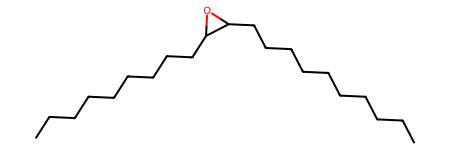

Prediction 0: CCCCC=CCC1OC1CC=CCCCCCCCCC, similarity: 0.4125874125874126

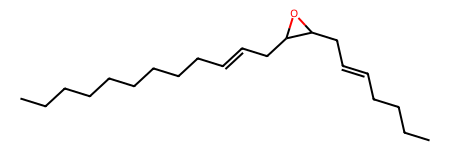

Prediction 1: CCCCCC=CC1OC1CC=CCCCCCCCCC, similarity: 0.30994152046783624

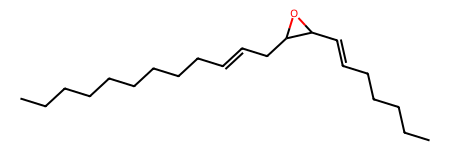

Prediction 2: CCCCCC=CCC=CCC(O)CCCCCCCCC, similarity: 0.3458646616541353

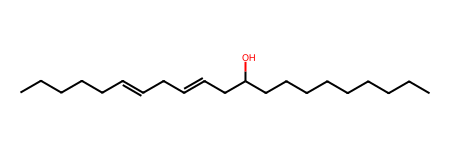

Prediction 3: CCCCCC=CCC=CCC1OC1CCCCCCCC, similarity: 0.5228758169934641

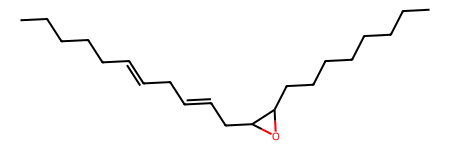

Prediction 4: CCCCCC=CCC=CCCC(=O)CCCCCCCC, similarity: 0.11038961038961038

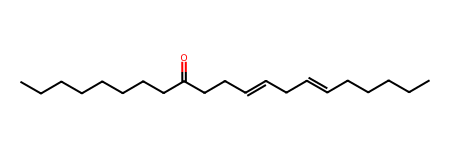

In [158]:
pairs_to_viz = list(zip(labels, sorted_predictions))[142]  # TODO: change this to visualize different pairs
best_n_to_viz = 5                                         # TODO: change this to visualize more/less predictions

if isinstance(pairs_to_viz, tuple):
    pairs_to_viz = [pairs_to_viz]

for gt_smiles, preds in pairs_to_viz:
    print("\n##################")
    print("GT smiles:", gt_smiles)
    gt_mol = Chem.MolFromSmiles(gt_smiles)
    display(gt_mol)
    for i, pred_smiles in enumerate(preds[:best_n_to_viz]):
        pred_mol = Chem.MolFromSmiles(pred_smiles)
        print(f"Prediction {i}: {pred_smiles}, similarity: {DataStructs.FingerprintSimilarity(Chem.RDKFingerprint(gt_mol), Chem.RDKFingerprint(pred_mol))}")
        display(pred_mol)

## Analyze performance compared to DB search
Here we briefly analyze the performance of the DB baseline compared to the best predictions of our model (the similsort mode).If you want to see only the compounds overlapping between the MACE dataset and the reference library, set `ONLY_OVERLAP` to `True`. 

In [15]:
from  utils.data_utils import filter_datapoints
from metrics import compute_fp_simils 

overlap # defined during DB sarch evaluation
sorted_predictions # defined during visualization
nist_train_jsonl_path = "../data/nist/train.jsonl"
mace_jsonl_precomputed_path = "../data/mace/MACE_r05_with_db_index.jsonl"

df_reference = pd.read_json(nist_train_jsonl_path, lines=True, orient="records")
df_labels = pd.read_json(mace_jsonl_precomputed_path, lines=True, orient="records")

# filter labels as in the generation process
labels_mask = df_labels.apply(lambda row: filter_datapoints(row, preprocess_args={"max_num_peaks": 300, 
                                                                                  "max_mz":500, 
                                                                                  "max_mol_repr_len": 100, 
                                                                                  "mol_repr": "smiles"}), axis=1)

df_labels_filtered = df_labels[labels_mask]

In [23]:
# prepare all the SMILES and similarities
ONLY_OVERLAP = False

def find_best_prediction(predictions, gt_smiles):
    simils = compute_fp_simils(predictions, [gt_smiles]*len(predictions))
    max_simil = max(simils)
    best_prediction = predictions[simils.index(max_simil)]
    return best_prediction, max_simil

df_labels_filtered["predictions"] = sorted_predictions


overlapped_mask = df_labels_filtered["smiles"].isin(overlap)
df_labels_filtered_overlapped = df_labels_filtered[overlapped_mask] if ONLY_OVERLAP else df_labels_filtered

df_labels_filtered_overlapped = df_labels_filtered_overlapped.join(df_reference, on="index_of_closest", rsuffix="_ref", how="inner")

df_labels_filtered_overlapped['best_prediction'], df_labels_filtered_overlapped['best_prediction_simil'] =  zip(*df_labels_filtered_overlapped.apply(lambda row: find_best_prediction(row["predictions"], row["smiles_ref"]), axis=1))

/tmp/ipykernel_2543931/2438652622.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_labels_filtered["predictions"] = sorted_predictions



##################
Example id: 97
GT smiles: CC(C)CCC(C)CCCC(C)CCCC(C)O


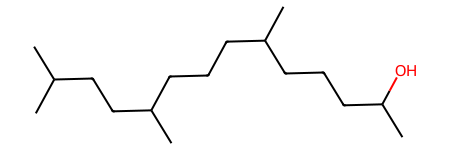

Best DB search candidate: CC(=O)CCCC(C)CCCC(C)CCCC(C)C similarity: 0.464285714285714


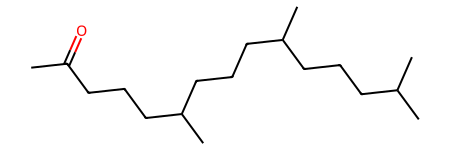

Best prediction: CC(=O)CCCC(C)CCCC(C)CCCC(C)C, similarity: 1.0


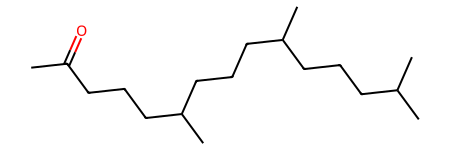


##################
Example id: 98
GT smiles: CCCCCCCCCCCCC(C)CCCC(C)O


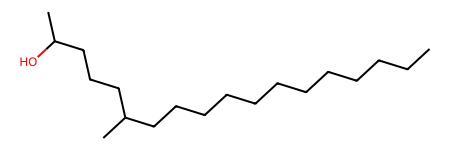

Best DB search candidate: CCCCCCCCCCCCCCCCCCCCCCCC(C)=O similarity: 0.310344827586206


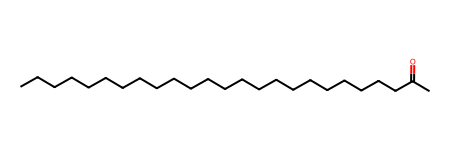

Best prediction: CCCCCCCCCCCCCCCCCC(C)=O, similarity: 1.0


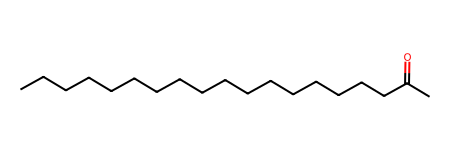


##################
Example id: 99
GT smiles: CCCCC(C)CCCCCCCCCCCC(C)O


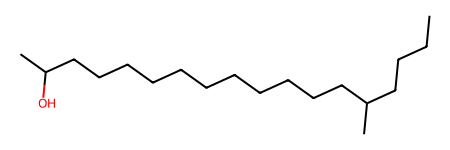

Best DB search candidate: CCCCCCCCCCCCCCCCCCCCCCCC(C)=O similarity: 0.275862068965517


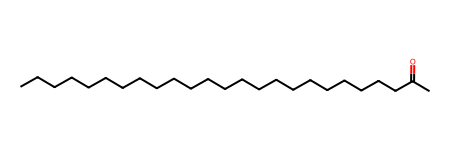

Best prediction: CCCCCCCCCCCCCCCCCC(C)=O, similarity: 1.0


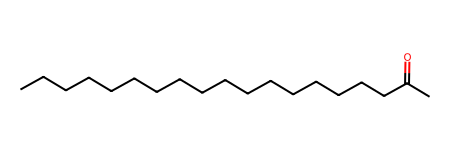


##################
Example id: 100
GT smiles: CCCCC(C)CCCCCCCC(C)CCCC(C)O


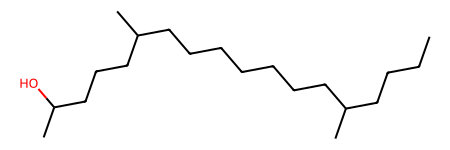

Best DB search candidate: CCCCCCCCCCCCCCCCCCCCCCCC(C)=O similarity: 0.266666666666666


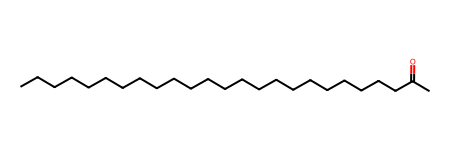

Best prediction: CCCCCCCCCCCCCCCCCCC(C)=O, similarity: 1.0


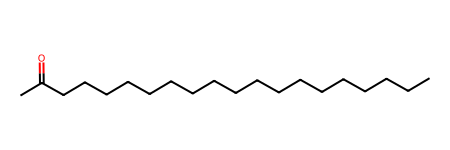


##################
Example id: 101
GT smiles: CCCCCCCCCCO


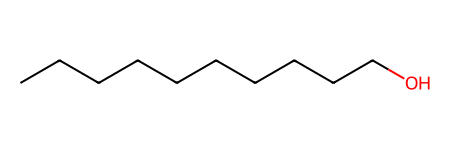

Best DB search candidate: CCCCCC=C=CCCCCCCCCCC(=O)OC similarity: 0.27272727272727204


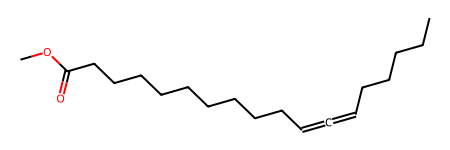

Best prediction: CC=CCCCCCCCOC(=O)CCCCCCCC, similarity: 0.6111111111111112


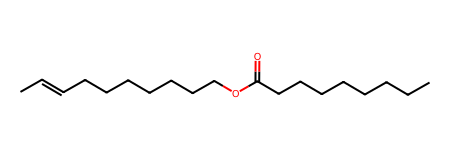


##################
Example id: 102
GT smiles: CCCCCCCCCCO


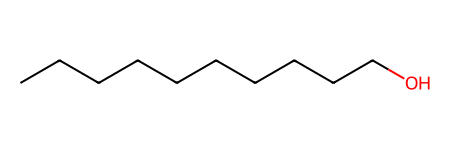

Best DB search candidate: C1=CCCCCCCCCC=C1 similarity: 0.0


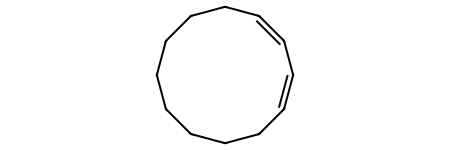

Best prediction: CCCCCC=CC=CCO, similarity: 0.7164179104477612


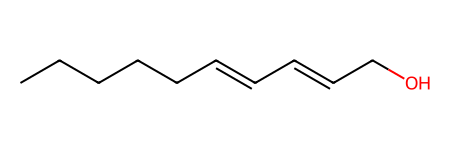


##################
Example id: 103
GT smiles: CCC(C)CCCCCCCCCC(C)CC(O)OC(CC)C(C)C


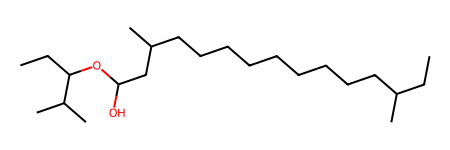

Best DB search candidate: CCCCS(=O)(=O)N1CCCCC1 similarity: 0.08333333333333301


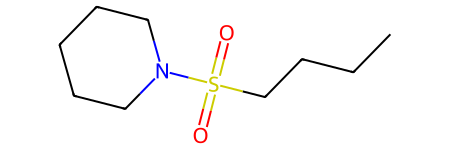

Best prediction: CCC(C)CCCCCCCCCCCC(=O)OC(C)(C)C(C)C, similarity: 0.06860158311345646


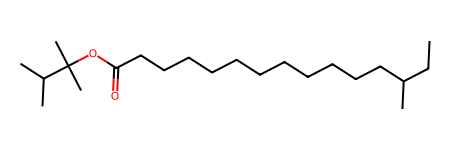


##################
Example id: 104
GT smiles: CCCCCCCCCC(C)CCCC(C)CCCC


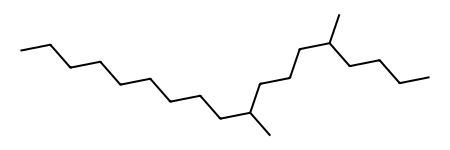

Best DB search candidate: CCCCCCCCCCCCCCCCCCCCCCCCCCOC(C)=O similarity: 0.275862068965517


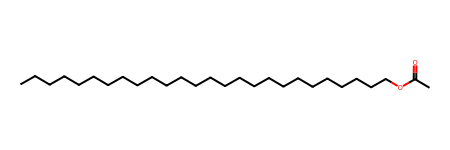

Best prediction: C=C(CCCCCCCC)CCCCCCCCCC, similarity: 0.15841584158415842


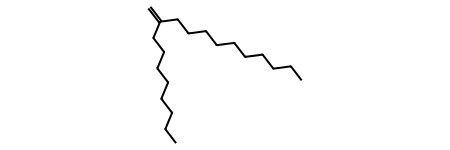


##################
Example id: 105
GT smiles: CCCCCCCCCCCCCCCCO


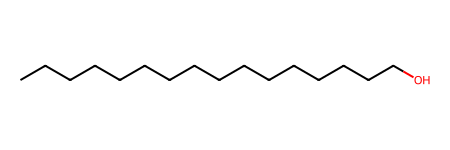

Best DB search candidate: CCCCC=CCCC=CCCCCCCOC(C)=O similarity: 0.25


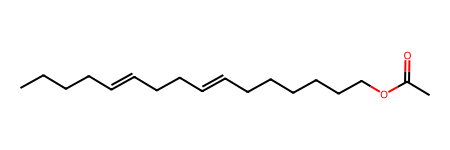

Best prediction: CCCCC=CCCCCCCCCCCCO, similarity: 0.4807692307692308


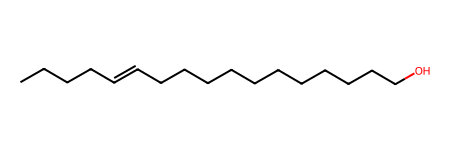


##################
Example id: 111
GT smiles: CCCCCCCCCCCCCCCCCCO


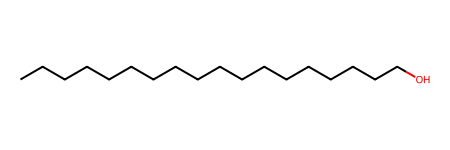

Best DB search candidate: CCCCC=CCCC=CCCCCCCOC(C)=O similarity: 0.25


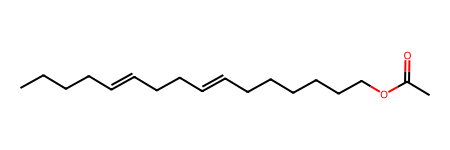

Best prediction: CCCCC=CCCCCCCCC=CCCCO, similarity: 0.4


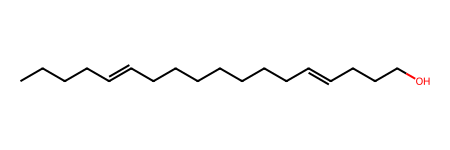


##################
Example id: 112
GT smiles: CCCCCCCCCCCCCCCCCCO


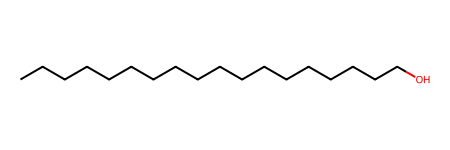

Best DB search candidate: CCCCC=CCCC=CCCCCCCOC(C)=O similarity: 0.25


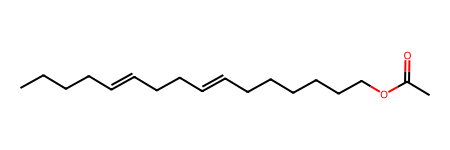

Best prediction: CCCCC=CCCCCCCCCCCC1CO1, similarity: 0.5040650406504065


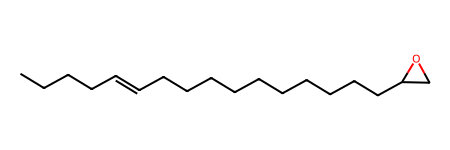


##################
Example id: 106
GT smiles: CCCCCCCCCCCCCCCCO


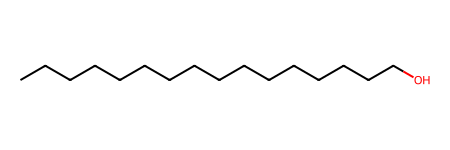

Best DB search candidate: CCCC=CCC=CCCCCCCCCCC(=O)OC similarity: 0.2


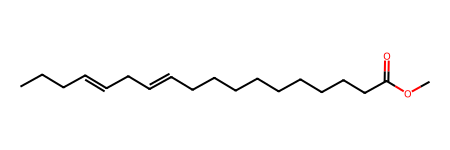

Best prediction: CCCCCC=CCC=CCCCCCC=O, similarity: 0.5636363636363636


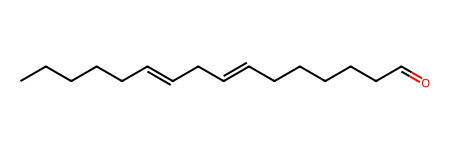


##################
Example id: 107
GT smiles: CCCCCCCCCCCCCCOC(C)O


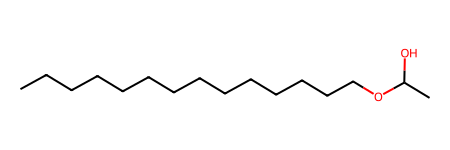

Best DB search candidate: CCCCCC=CCC=CCCCCC=CCCCC(=O)OC similarity: 0.23076923076923


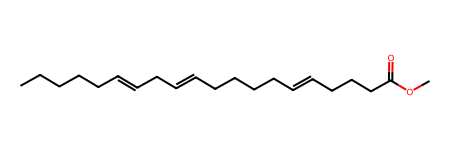

Best prediction: C=CCCCCC=CCC=CCCC, similarity: 0.4380952380952381


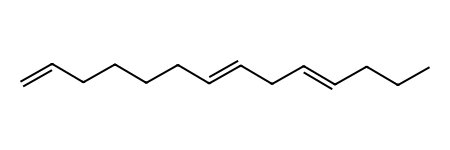


##################
Example id: 108
GT smiles: CCCCCCCCCCCCCCCCOC(C)O


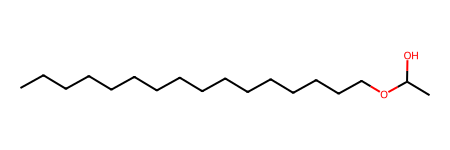

Best DB search candidate: CCC=CCCCCCCCCCCOC(C)=O similarity: 0.243243243243243


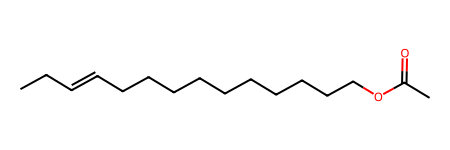

Best prediction: CCC=CCCCCCCCCCCCCCOC(C)=O, similarity: 1.0


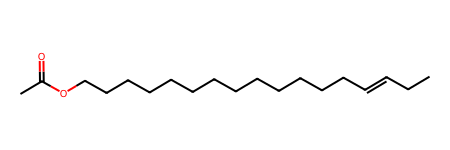


##################
Example id: 109
GT smiles: CCCCCCCCCCCCCCCCOC(C)O


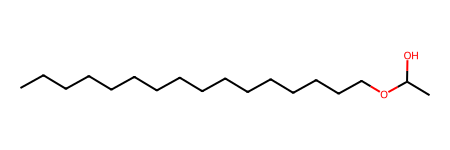

Best DB search candidate: O=C1CCCCCCCC=CCCCCCCCCO1 similarity: 0.023809523809523003


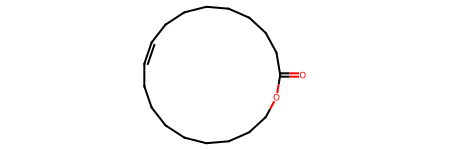

Best prediction: CC=CCCCCCCCCCCCCCOC(C)=O, similarity: 0.7741935483870968


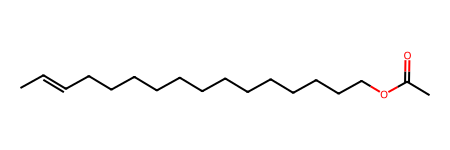


##################
Example id: 110
GT smiles: CCCCCCCCCCCCCCCCOC(C)O


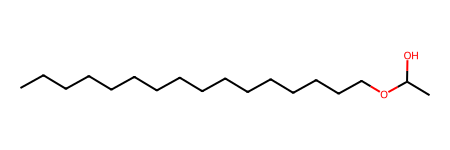

Best DB search candidate: O=C1CCCCCCCC=CCCCCCCCCO1 similarity: 0.023809523809523003


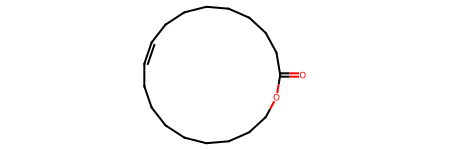

Best prediction: CCCCC=CCCCCCCCCCCOC(=O)CCCCCCCC, similarity: 1.0


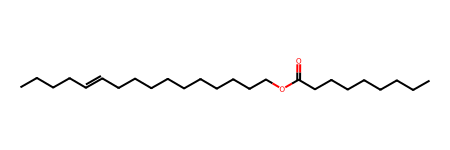


##################
Example id: 113
GT smiles: CCCCCCCCCCCCCCCCCCOC(C)O


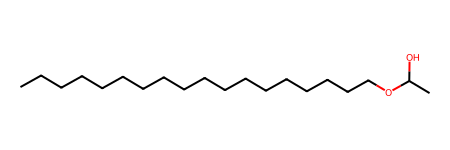

Best DB search candidate: CCCCCC=CCC=CCCCCCCCC(=O)O similarity: 0.243243243243243


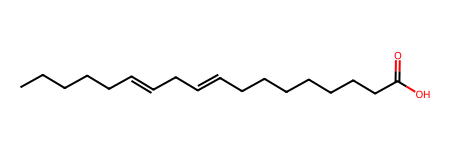

Best prediction: CCCCC=CCCCCCCCCC=CCCCCCO, similarity: 0.5434782608695652


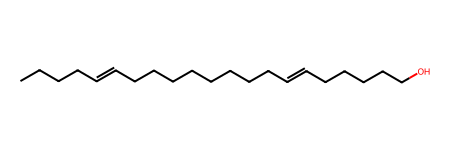


##################
Example id: 114
GT smiles: CCCCCCCCCCCCCCCCCCOC(C)O


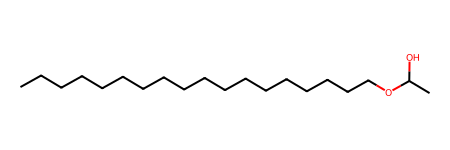

Best DB search candidate: CCCCCC=CCC=CCCCCCCCC(=O)O similarity: 0.243243243243243


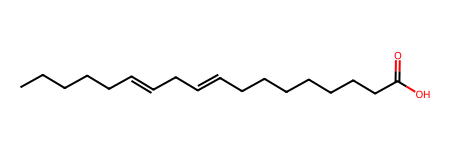

Best prediction: C=CCCCCCCCC(=O)OCCC=CCCCCCCCCC=CCCCC, similarity: 0.5197368421052632


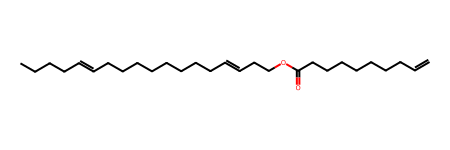


##################
Example id: 115
GT smiles: CCCCCCCCCCCCCCCCCCO


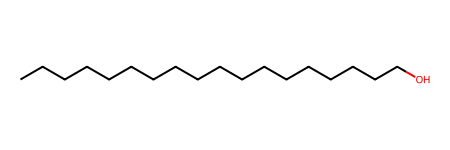

Best DB search candidate: CCC(C)CCCCC#CCCCCCCCO similarity: 0.35714285714285704


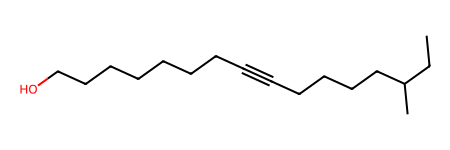

Best prediction: CC#CCCCCCCCCCCCCCCCO, similarity: 0.7611940298507462


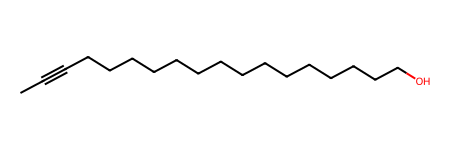


##################
Example id: 116
GT smiles: CCCCCCCCCCCCCCCCCCOC(C)O


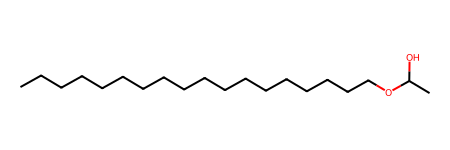

Best DB search candidate: CCCCCCCCC=CCCCCCCC=CCCCC(=O)OC similarity: 0.277777777777777


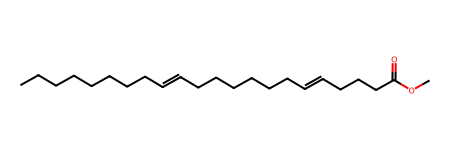

Best prediction: CCCCC=CCCCCCCCC=CCCCCO, similarity: 0.5360824742268041


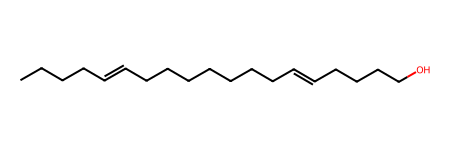


##################
Example id: 118
GT smiles: CCCCCCCCCCCCCCCC1OC1CC


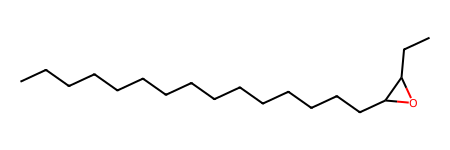

Best DB search candidate: CCCCCC=CCC=CCC=CCC=CCC=CCCC(=O)OC similarity: 0.17073170731707302


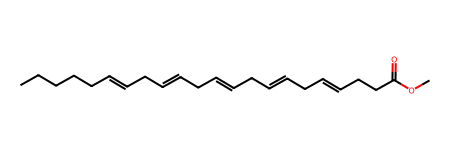

Best prediction: CCCCCCC=CCC=CCC=CCCC(=O)OC, similarity: 0.9636363636363636


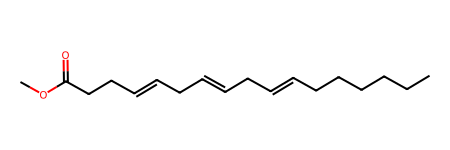


##################
Example id: 123
GT smiles: CCCCCCCCCCCCCCCCCC1OC1CC


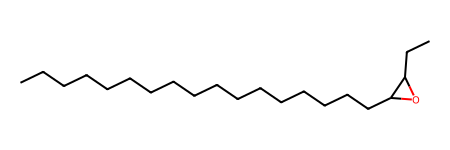

Best DB search candidate: CCCCCC=CCC=CCC=CCC=CCC=CCCC(=O)OC similarity: 0.17073170731707302


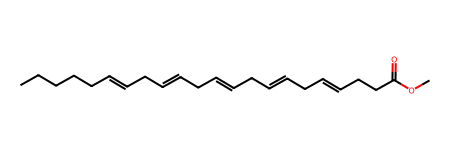

Best prediction: CCCCCC=CCC=CCC=CCC=CCCC(=O)OC, similarity: 1.0


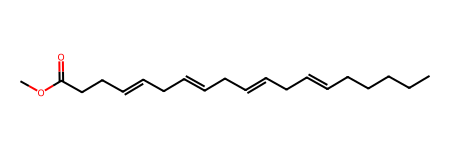


##################
Example id: 121
GT smiles: CCCCCCCCCCC1OC1CCCCCCC


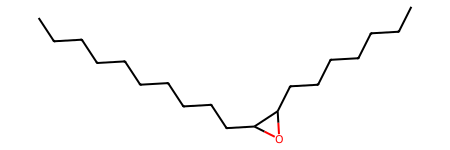

Best DB search candidate: CCC=CCC=CCC=CCC=CCCCCC(=O)OCCCC similarity: 0.13953488372093


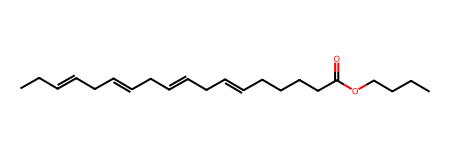

Best prediction: CCC=CCC=CCC=CCC=CCCCCCCO, similarity: 0.4264705882352941


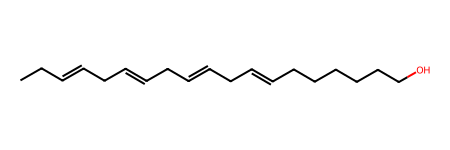


##################
Example id: 138
GT smiles: CCCCCCCCCCC1OC1CCCCCCCCC


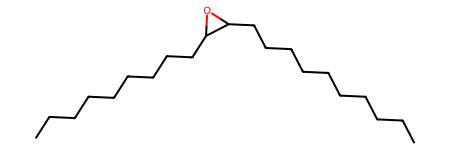

Best DB search candidate: CCC=CCC=CCC=CCC=CCCCCC(=O)OCCCC similarity: 0.13953488372093


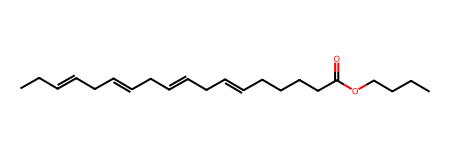

Best prediction: CCC=CCC=CCC=CCC=CCCCCCCCCO, similarity: 0.42028985507246375


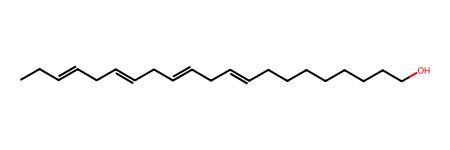


##################
Example id: 122
GT smiles: CCCCCCCCCCC(O)CCCCCCCC


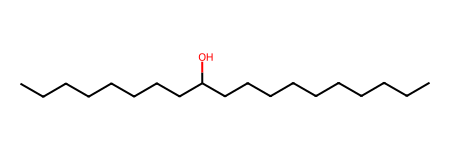

Best DB search candidate: CC1(C)C2CC3OC3(C)C1C2 similarity: 0.027777777777777003


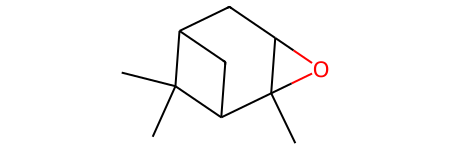

Best prediction: CCCC=CCC=CCCC1OC2CCCCC2C1C, similarity: 0.45698924731182794


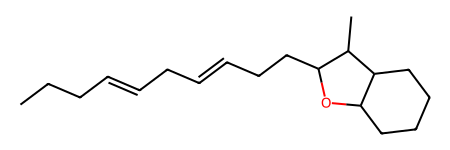


##################
Example id: 126
GT smiles: CC1CCC(C(C)CO)CC1


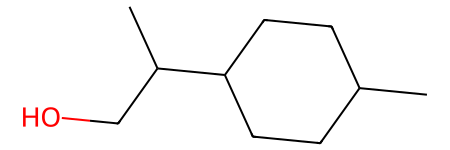

Best DB search candidate: C=CC(C)C(O)c1ccc(C)cc1 similarity: 0.128205128205128


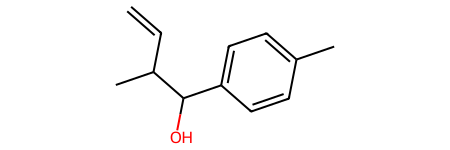

Best prediction: CC1=CC2C(CC1CO)C2(C)C, similarity: 0.10583153347732181


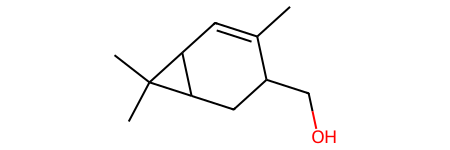


##################
Example id: 127
GT smiles: CCC(O)CC1OC(C)CCC1C


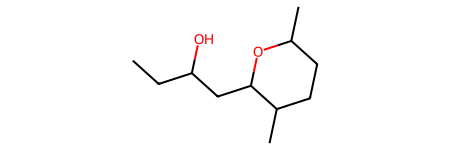

Best DB search candidate: CC(COC(=O)CCC(=O)Oc1cccc(Cl)c1)CC(C)(C)C similarity: 0.078125


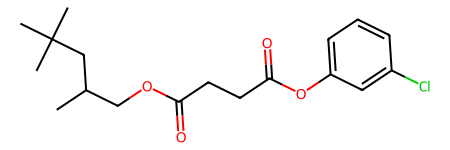

Best prediction: CCC1CCC2(CCCC(=O)O2)O1, similarity: 0.22279792746113988


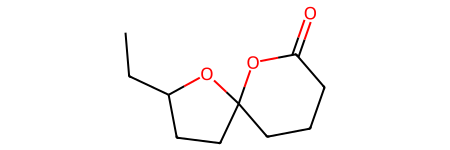


##################
Example id: 128
GT smiles: CCC1OC1CCCCCO


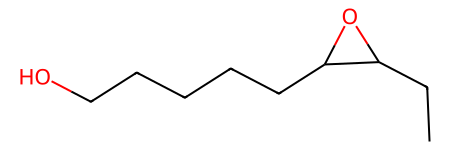

Best DB search candidate: CCC1OC1CCCCCCCCCCO similarity: 1.0


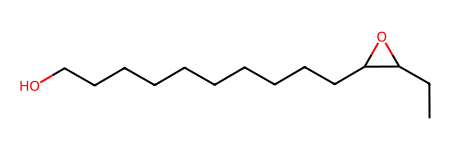

Best prediction: CCCCCC1OC1CCCC, similarity: 1.0


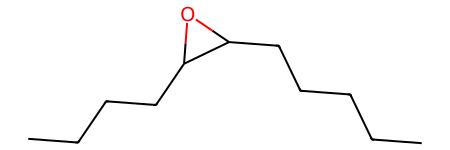


##################
Example id: 129
GT smiles: CC(C)CCCC(C)CCCC(C)CO


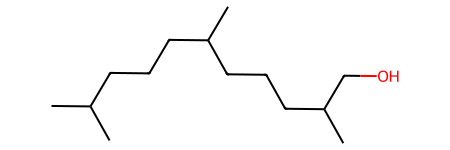

Best DB search candidate: CC(C)=CCCC(C)=CCCC=CCO similarity: 0.105263157894736


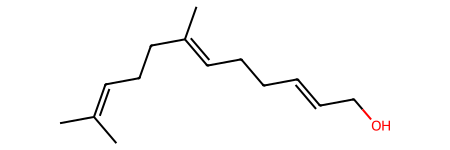

Best prediction: CC(C)=CCCC(C)=CCCC=CCO, similarity: 1.0


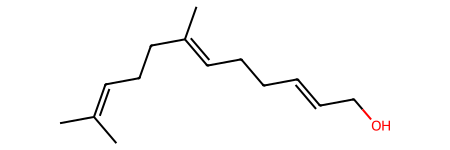


##################
Example id: 131
GT smiles: CC(C)CCC1OC(O)CC1C


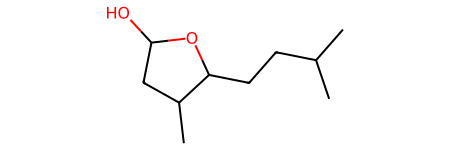

Best DB search candidate: CCCCCC(=O)OC(=O)CCCCC similarity: 0.073170731707317


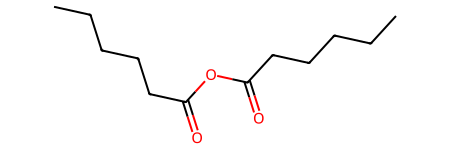

Best prediction: CC1CCC(C(C)C)OC(=O)C1, similarity: 0.4052863436123348


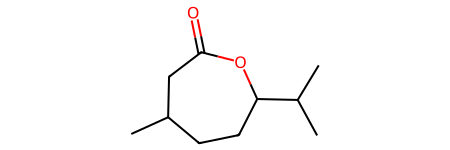


##################
Example id: 132
GT smiles: CCCC1OC(O)C(C)C1C


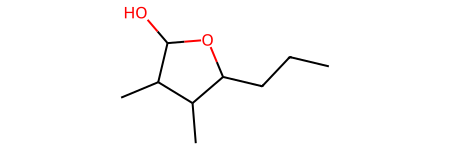

Best DB search candidate: O=C([Se]c1ccccc1)C1CCCCC1 similarity: 0.044444444444444


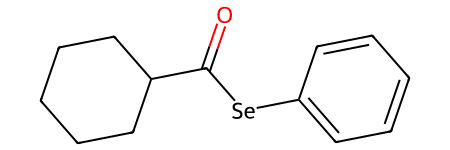

Best prediction: CC=C(C)C(=O)C(C)CCC, similarity: 0.14084507042253522


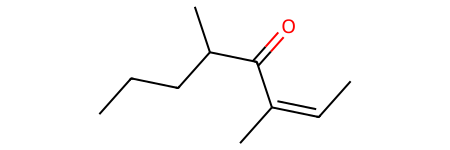


##################
Example id: 133
GT smiles: CC(C)CCC1OC(O)CC1C


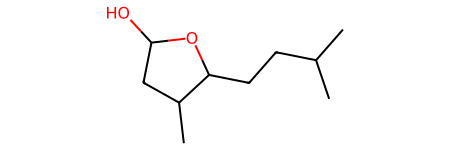

Best DB search candidate: CCCCCC1CCCC(=O)O1 similarity: 0.125


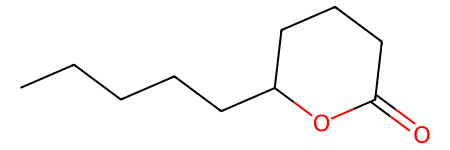

Best prediction: CC1CCC(C(C)C)OC(=O)C1, similarity: 0.6371681415929203


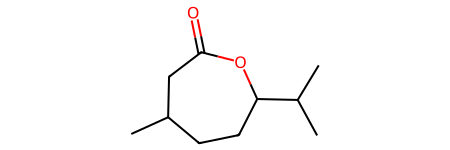


##################
Example id: 134
GT smiles: CC1CCCC(C)(C)C1CO


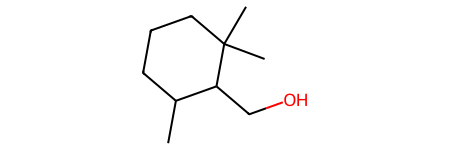

Best DB search candidate: CC(C)=CC1C(COC(=O)C(O)C(C)C)C1(C)C similarity: 0.145833333333333


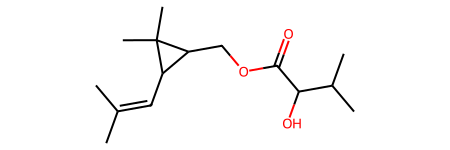

Best prediction: CC1=C(CO)C(C)(C)CCC1, similarity: 0.2597701149425287


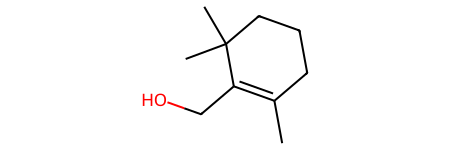


##################
Example id: 135
GT smiles: CC1(C)CCCC(C)(O)C1O


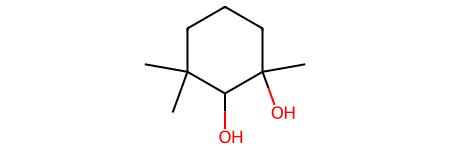

Best DB search candidate: CC1CCCC(C)C1O similarity: 0.22222222222222202


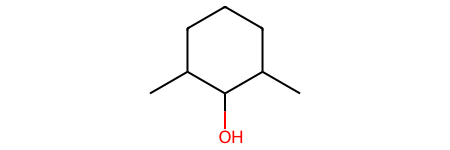

Best prediction: CC(C)C1CCC(O)C(C)C1, similarity: 0.7431192660550459


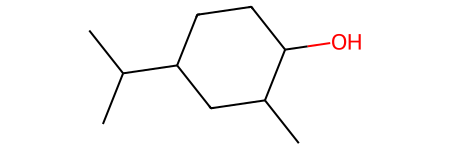


##################
Example id: 136
GT smiles: CC(C)CCC1OC(O)CC1C


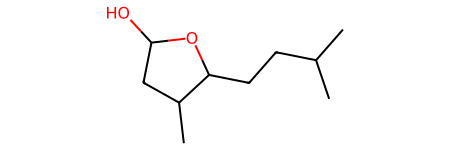

Best DB search candidate: OCc1ncc[nH]1 similarity: 0.046511627906976


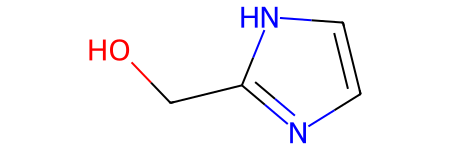

Best prediction: CCC=CC1OC(=O)CC1(C)C, similarity: 0.036619718309859155


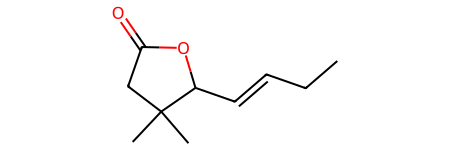


##################
Example id: 137
GT smiles: CC1CCCC(C)(C)C1O


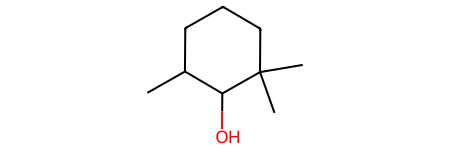

Best DB search candidate: CC1=CC(=O)CC(C)(C)C1 similarity: 0.14285714285714202


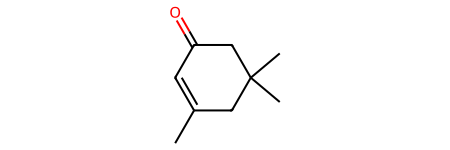

Best prediction: CC1=CC(=O)CC(C)(C)C1, similarity: 1.0


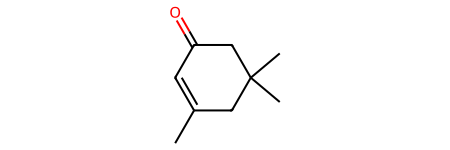


##################
Example id: 139
GT smiles: CCCCCCCCCCCCC(O)CCCCCCCC


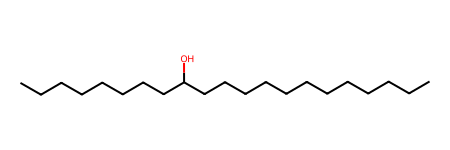

Best DB search candidate: C(#CCOB1C2CCCC1CCC2)COB1C2CCCC1CCC2 similarity: 0.028571428571428


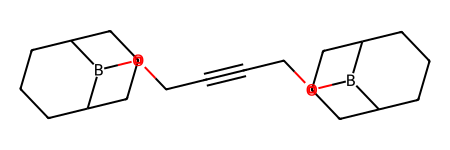

Best prediction: C=CCC=CCCCCCCCC1CC=CC(CC)C(=O)O1, similarity: 0.09696969696969697


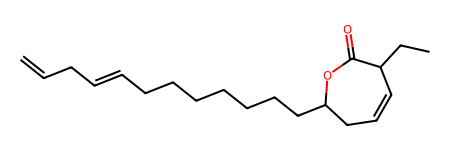


##################
Example id: 140
GT smiles: CCCCCCCCCCCCC1OC1CCCCC


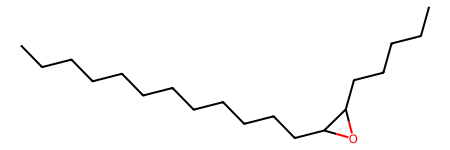

Best DB search candidate: CCCCCC=CCC=CCC1OC1CC=CCCCC(=O)OC similarity: 0.28571428571428503


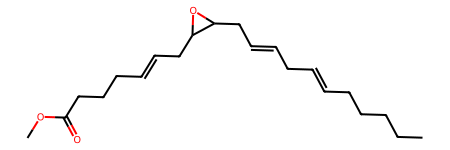

Best prediction: CCCCCC=CCC=CCC=CCCCCCCO, similarity: 0.3


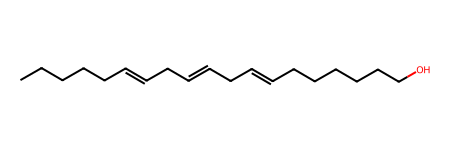


##################
Example id: 141
GT smiles: CCCCCCCCCC1OC1CCCCCCCC


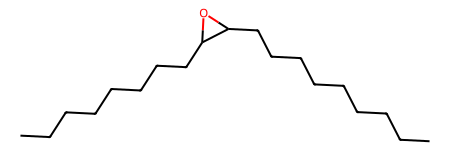

Best DB search candidate: CCCCCCC1CCS(=O)(=O)CC1 similarity: 0.36666666666666603


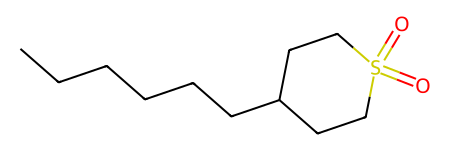

Best prediction: CCCCCC=CCC1CCCCC1CCCCCC, similarity: 0.18461538461538463


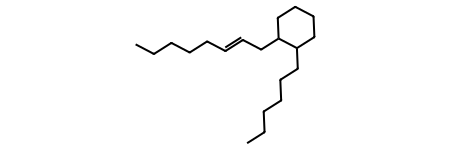


##################
Example id: 143
GT smiles: CCCCCCCCCCC(O)CCCCCCCC


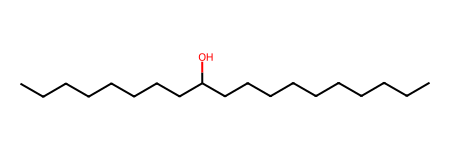

Best DB search candidate: CCCCCCC1CCS(=O)(=O)CC1 similarity: 0.25


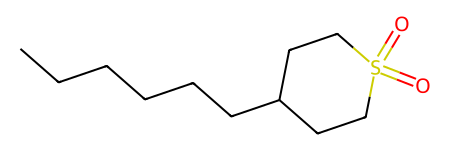

Best prediction: CCC=CCCC(C)C(=O)CCC=CCCCCCC, similarity: 0.13215859030837004


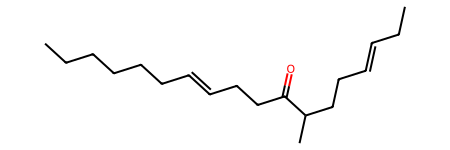


##################
Example id: 145
GT smiles: CCCCCCCCCCCC1OC1CCCCCCCC


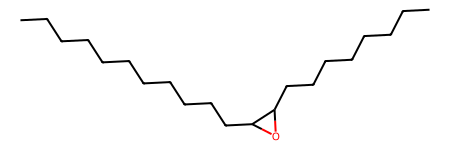

Best DB search candidate: CCCCCCC1CCS(=O)(=O)CC1 similarity: 0.36666666666666603


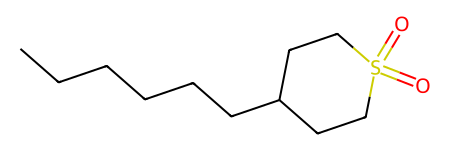

Best prediction: CCCCCC=CCC1CCC(CCCCCCC)C(=O)C1, similarity: 0.16393442622950818


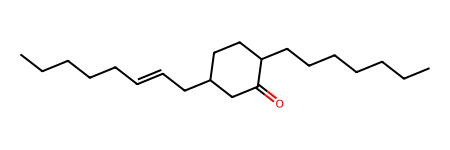


##################
Example id: 142
GT smiles: CCCCCCCCCCC1OC1CCCCCCC


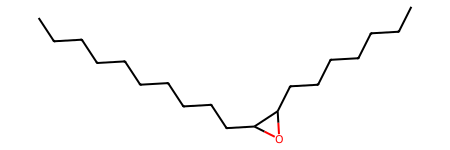

Best DB search candidate: CCCCCCCCCCC#CCOC(=O)CCCCCCC similarity: 0.216216216216216


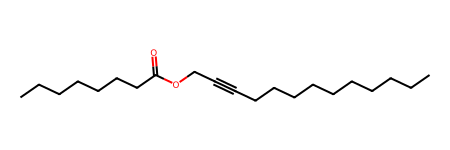

Best prediction: CCCCCC=CCC=CCC1OC(=O)C(CC)C1C, similarity: 0.22962962962962963


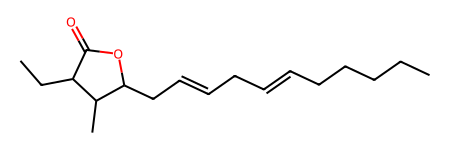


##################
Example id: 144
GT smiles: CCCCCCCCCCCCCCC1OC1CCCCC


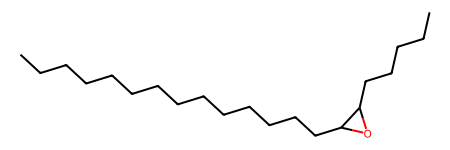

Best DB search candidate: CCCCCC=CCC=CCC=CCCCCCCCCC(=O)OC similarity: 0.210526315789473


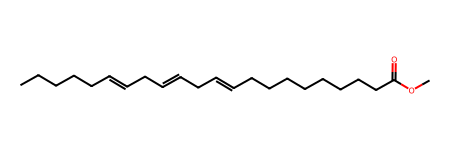

Best prediction: CCCCCC=CCC=CCC=CCCCCCCCCO, similarity: 0.5892857142857143


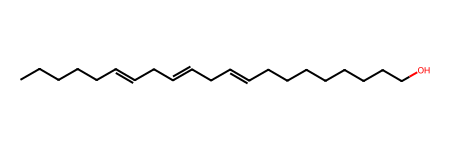


##################
Example id: 146
GT smiles: CCCCCCCCCCC1OC1CCCCCCCCC


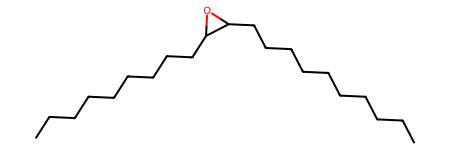

Best DB search candidate: CCCCCC1OC1CC1OC1CCCCCCCC(=O)OCC similarity: 0.515151515151515


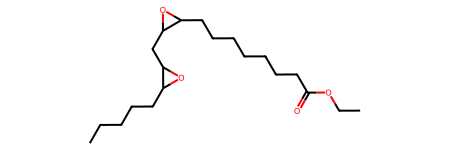

Best prediction: CCCCCCCCCC=CCC1OC1CCCCCCC, similarity: 0.3620689655172414


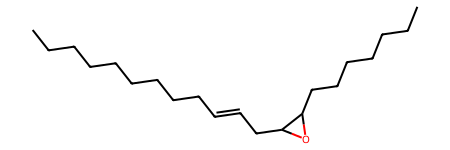


##################
Example id: 215
GT smiles: CCCCCCCCCCCCCCCCCC(O)OCCC(O)CCCCCCC


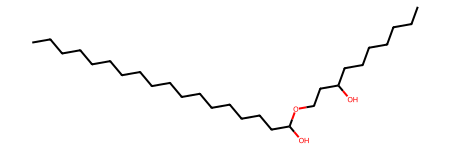

Best DB search candidate: CCCCCC1OC1CC1OC1CCCCCCCC(=O)OCC similarity: 0.234042553191489


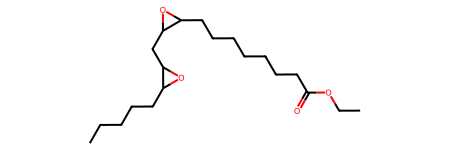

Best prediction: CCCCCCCCC=CCCCCCCCC(=O)OCCCCCCCCCCC, similarity: 0.45365853658536587


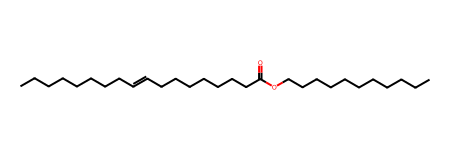


##################
Example id: 148
GT smiles: CC1CCCC(C)OC(O)C(C)CCC1


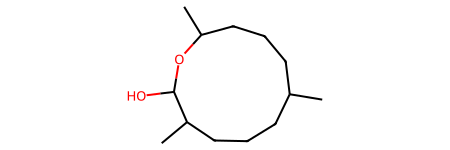

Best DB search candidate: CCCCCCCCC=CCCCCC1CCC(=O)O1 similarity: 0.09803921568627401


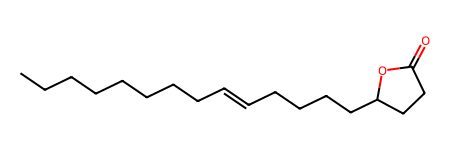

Best prediction: C=C1CCCC(C)C1CC1CCC(=O)O1, similarity: 0.5442622950819672


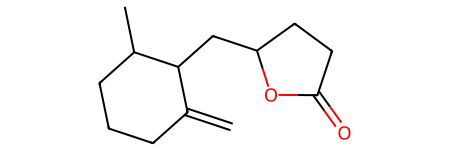


##################
Example id: 149
GT smiles: CCC(C)CSSCC(C)C


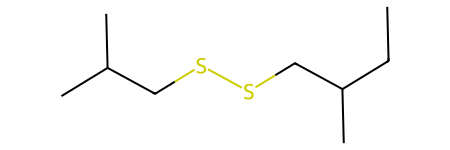

Best DB search candidate: CCCCSSCCC(C)C similarity: 0.28571428571428503


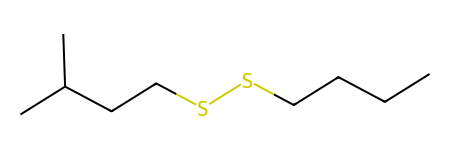

Best prediction: CC(C)(C)CSSCC(C)(C)C, similarity: 0.5


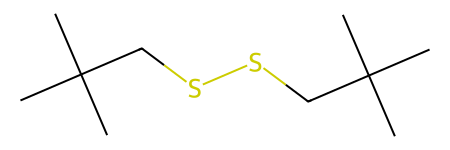


##################
Example id: 153
GT smiles: CCCCSSCC(C)CC


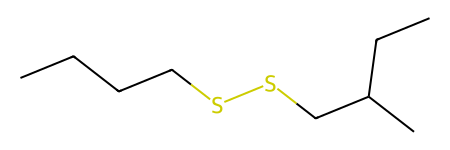

Best DB search candidate: CCCCSSCCC(C)C similarity: 0.538461538461538


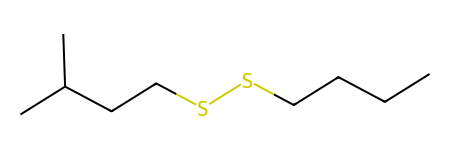

Best prediction: CC(C)CCSSCC(C)C, similarity: 0.8571428571428571


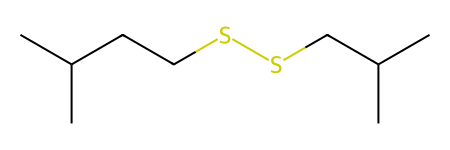


##################
Example id: 156
GT smiles: CCCCSSCCC(C)C


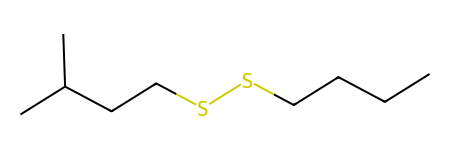

Best DB search candidate: CCCCSSCCC(C)C similarity: 1.0


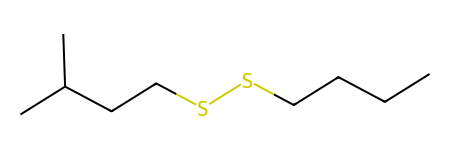

Best prediction: CC(C)CCSSCCC(C)C, similarity: 1.0


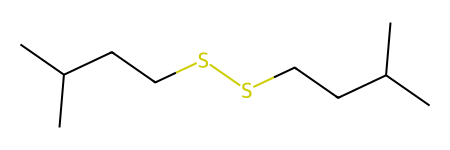


##################
Example id: 150
GT smiles: CCC(C)CSSCC(C)CC


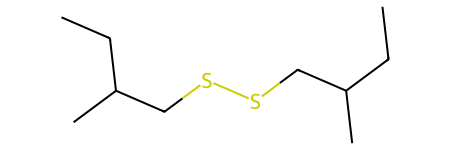

Best DB search candidate: CCC(C)(C)SSC(C)(C)CC similarity: 0.18181818181818102


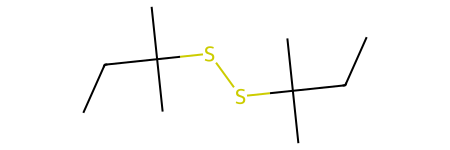

Best prediction: CCC(C)(C)SSCCC(C)C, similarity: 0.8292682926829268


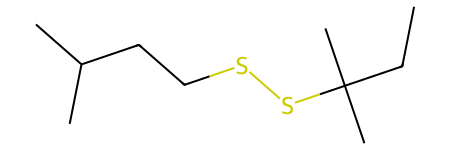


##################
Example id: 151
GT smiles: CCC(C)CSSCCC(C)C


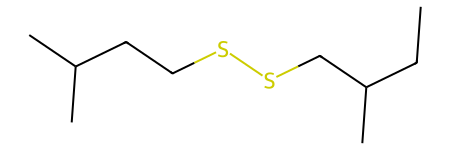

Best DB search candidate: CC(C)CCSSCCC(C)C similarity: 0.6190476190476191


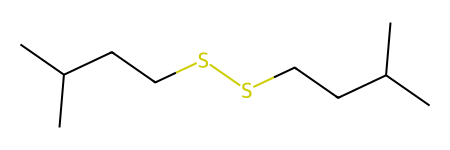

Best prediction: CC(C)CCSSCCC(C)C, similarity: 1.0


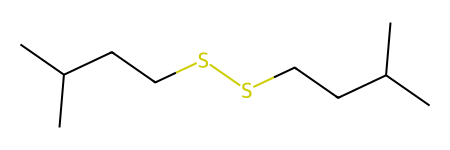


##################
Example id: 158
GT smiles: CCCCCSSCC(C)CC


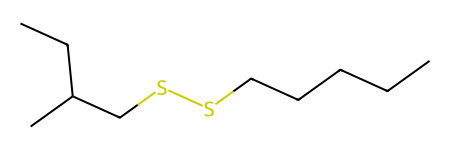

Best DB search candidate: CC(C)CCSSCCC(C)C similarity: 0.296296296296296


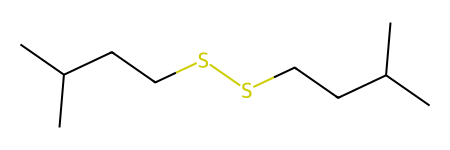

Best prediction: CC(C)CCSSCCC(C)C, similarity: 1.0


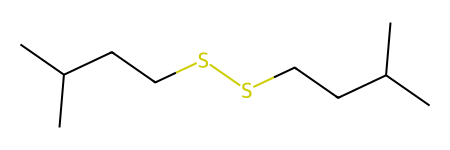


##################
Example id: 152
GT smiles: CC(C)CCSSCC(C)C


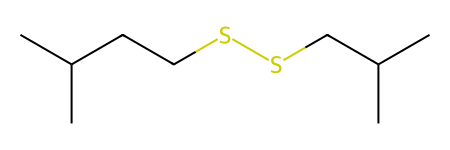

Best DB search candidate: CCCCCSSCC(C)C similarity: 0.5416666666666661


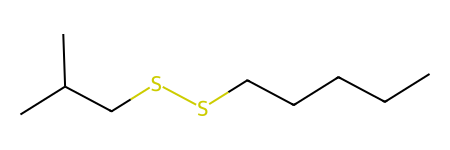

Best prediction: CC(C)CCSSCC(C)C, similarity: 0.75


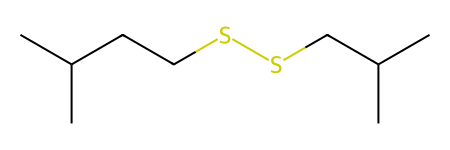


##################
Example id: 159
GT smiles: CCCCCSSCC(C)C


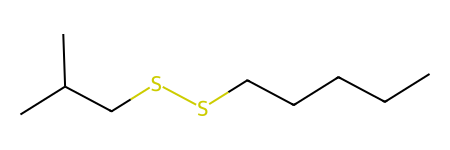

Best DB search candidate: CCCCCSSCC(C)C similarity: 1.0


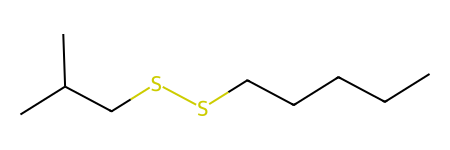

Best prediction: CCCCSSCC(C)C, similarity: 0.8571428571428571


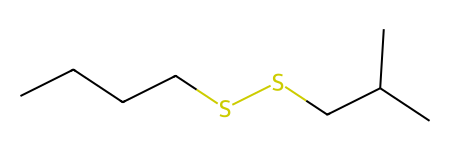


##################
Example id: 154
GT smiles: CCCSSCC(C)C


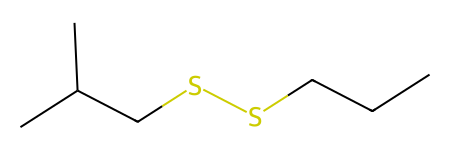

Best DB search candidate: CCC(C)OC(=O)C1CC(OC(=O)C(F)(F)F)CN1C(=O)C(F)(F)F similarity: 0.092592592592592


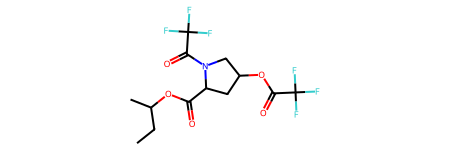

Best prediction: CCc1ccc(SSC(C)CC)cc1, similarity: 0.08294392523364486


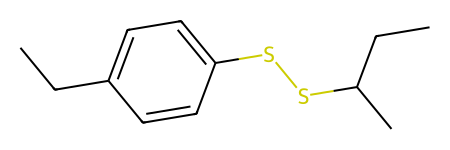


##################
Example id: 155
GT smiles: CCCSSCC(C)CC


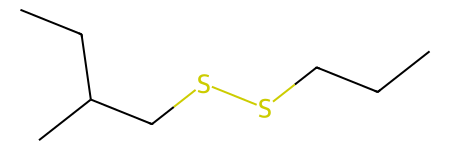

Best DB search candidate: CCCCCSSCCC similarity: 0.416666666666666


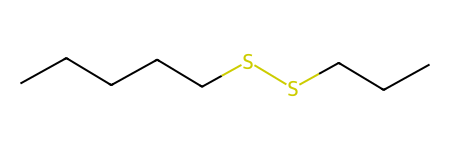

Best prediction: CCCCCSSCCC, similarity: 1.0


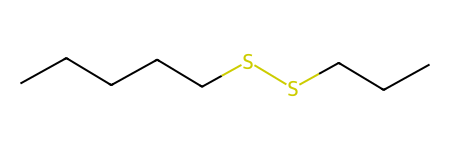


##################
Example id: 157
GT smiles: CCSSCC(C)CC


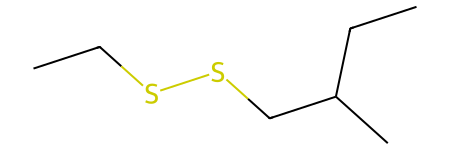

Best DB search candidate: CCCCCSSCC similarity: 0.32


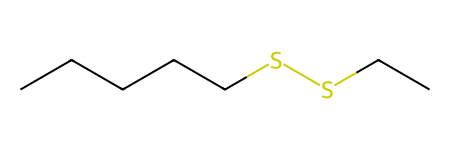

Best prediction: CCCCCSSC(C)C, similarity: 0.8214285714285714


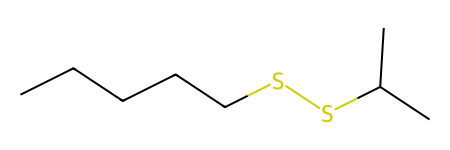


##################
Example id: 160
GT smiles: CC1CCCC(C)COC(O)C(C)CCC1


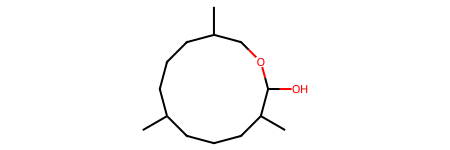

Best DB search candidate: C=C1CCCC(C)(C)C1CCCO similarity: 0.106382978723404


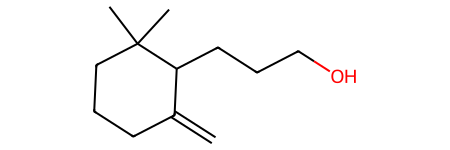

Best prediction: C=C1CCCC(C)C(=O)OCCC(C)CC1, similarity: 0.3159851301115242


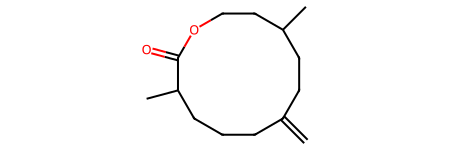


##################
Example id: 161
GT smiles: CCCCCCCCCCCCCCCCCCCCCCCCCCCCC


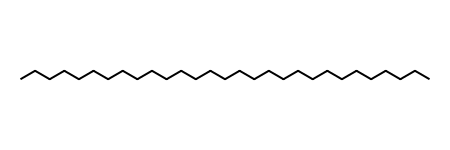

Best DB search candidate: CCCCCCCCCCCCCCCCCCCCCCCCCCCCO similarity: 0.6153846153846151


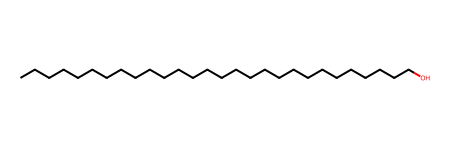

Best prediction: C=CCCCCCCCCCCCCCCCCCCCCCCCCCCC, similarity: 0.3333333333333333


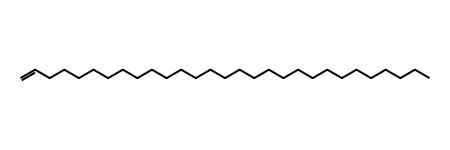


##################
Example id: 162
GT smiles: CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC


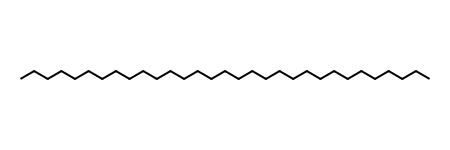

Best DB search candidate: CCCCCCCCC=CCCCCCCCCCCCCO similarity: 0.421052631578947


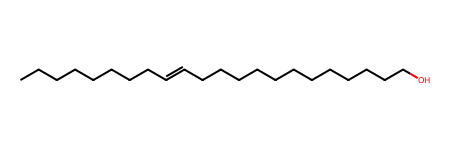

Best prediction: CCCCCCC=CCCCCCCCCCCCCCCCCCCCCCCC, similarity: 0.7307692307692307


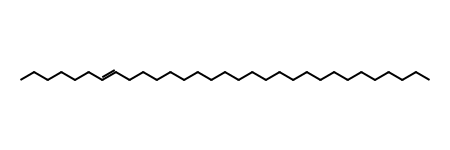


##################
Example id: 163
GT smiles: CCCC(C)CCCCCCCCCCCCCCCCCCCCCC(C)COC


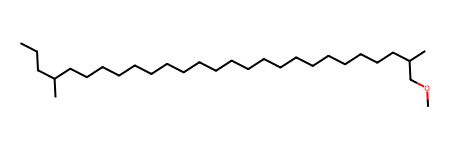

Best DB search candidate: CCCC(C)CCCCCCCCCCCCOC similarity: 0.76


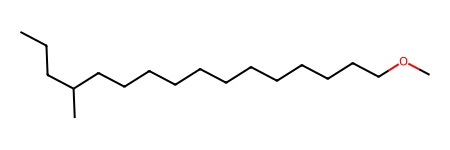

Best prediction: CCC(C)CCCCCCCCCCCCCCCCCCCCCCCCOC, similarity: 1.0


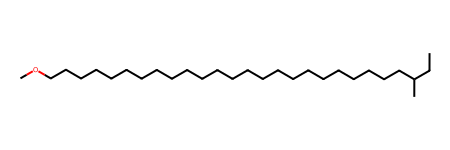


##################
Example id: 164
GT smiles: CCCC(C)CCCCCCCCCCCCCCCCCCCCCCCOC


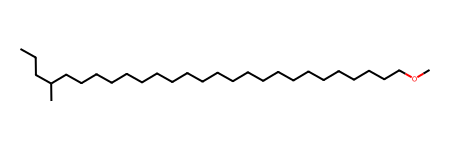

Best DB search candidate: CCCC(C)CCCCCCCCCCCCOC similarity: 1.0


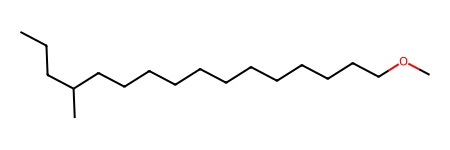

Best prediction: CCCCCCCCCCCCCCCCCCCCCCCCC(C)CCOC, similarity: 0.8615384615384616


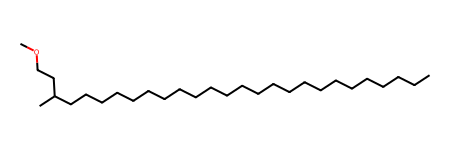


##################
Example id: 165
GT smiles: CCCC(C)CCCCCCCCCCCCCC(C)CCCCCCCC(C)COC


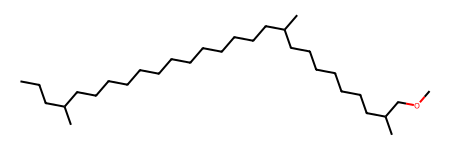

Best DB search candidate: CCCCCCCCCCCCCCCCCCCCCCCCCCCOC(=O)C(F)(F)C(F)(F)C(F)(F)F similarity: 0.19047619047619002


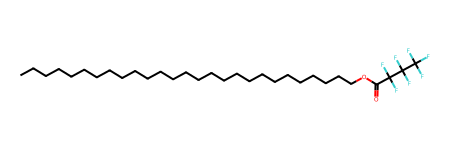

Best prediction: CC(C)CCCC(C)CCCC(C)CCCCC(C)CCCC(C)CCOC(=O)C(F)(F)F, similarity: 0.290167865707434


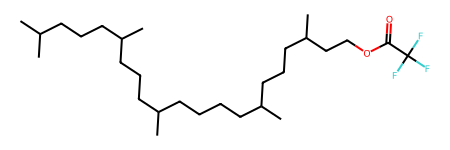


##################
Example id: 166
GT smiles: CC(O)OCC1CC(C(C)C)C1(C)C


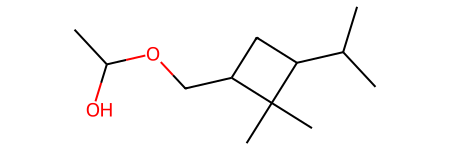

Best DB search candidate: CC=CC1CCC1C=CC similarity: 0.11111111111111101


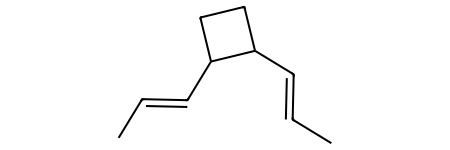

Best prediction: C=C(C)C1CC=C(C)CCOC(=O)C1, similarity: 0.20748299319727892


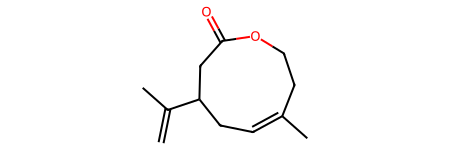


##################
Example id: 167
GT smiles: CC(C)CCC(COC(C)O)C(C)C


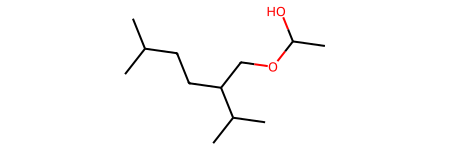

Best DB search candidate: CC(C)=C1C=CC(C)CC1 similarity: 0.048780487804878


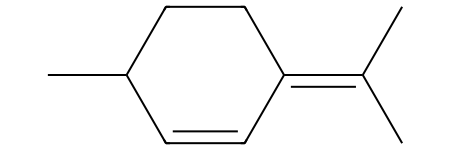

Best prediction: CC1=CC(C)C(C(C)CC(=O)O)CC1, similarity: 0.3115942028985507


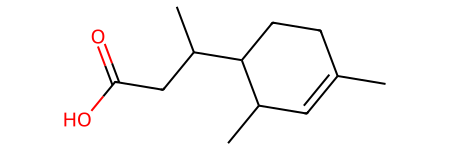


##################
Example id: 168
GT smiles: CCOC(O)CCCCCC(C)C


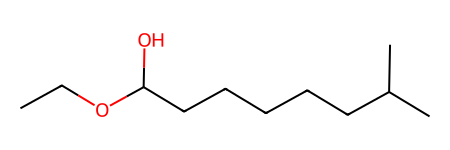

Best DB search candidate: CCCCCC=CCCCOC(=O)CCC(=O)OC(C)C(C)C similarity: 0.1875


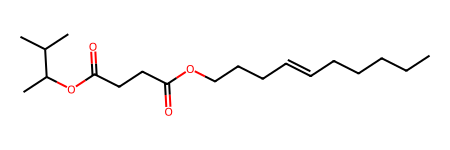

Best prediction: CCCCCCC=CCCOC(=O)CCC, similarity: 0.49748743718592964


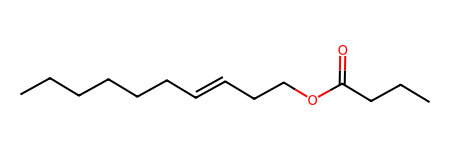


##################
Example id: 169
GT smiles: CCOC(O)CCCCCC(C)C


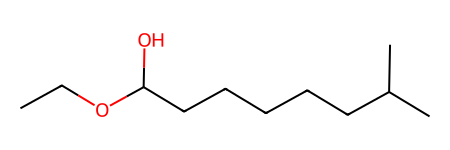

Best DB search candidate: CCCCCC=CCCCOC(=O)CCC(=O)OC(C)C(C)C similarity: 0.1875


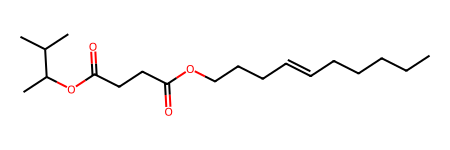

Best prediction: CCCCCC=CCCOC(=O)CCC, similarity: 0.5076923076923077


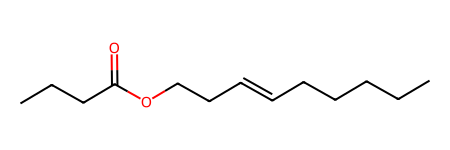


##################
Example id: 170
GT smiles: CC(C)CCCCCC(O)OC(C)C


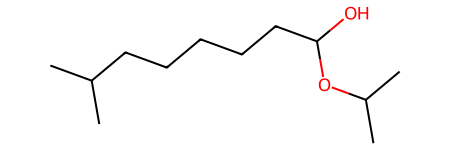

Best DB search candidate: CCCCCC=CCCCOC(=O)CCC(=O)OC(C)C(C)C similarity: 0.14285714285714202


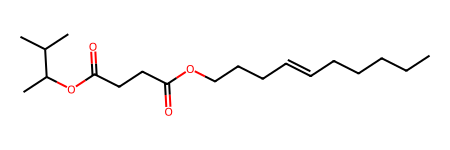

Best prediction: CCCCCC=CC(C)CCOC(=O)CCC, similarity: 0.5665024630541872


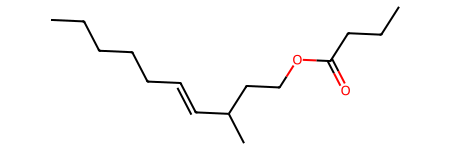


##################
Example id: 171
GT smiles: CC(C)CCCCCC(O)OC(C)C


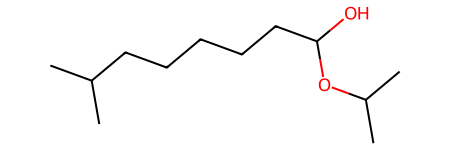

Best DB search candidate: CCCCCC=CCCCOC(=O)CCC(=O)OC(C)C(C)C similarity: 0.14285714285714202


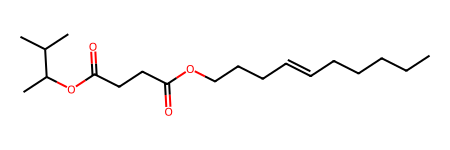

Best prediction: CC(C)CCCC(C)C(CC(=O)O)C(=O)O, similarity: 0.21942446043165467


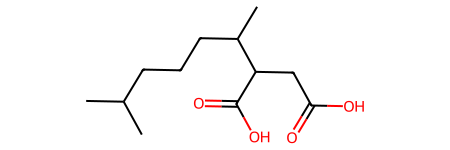


##################
Example id: 172
GT smiles: CCOC(O)CCCCCC(C)CC


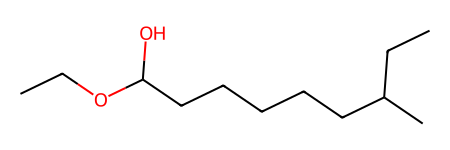

Best DB search candidate: CCCCCC=CCCC(=O)OCC similarity: 0.162790697674418


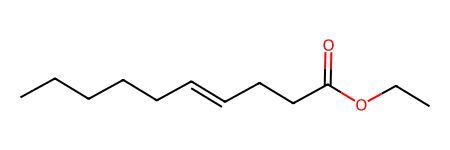

Best prediction: CCCCCC=CCCC(=O)OCC, similarity: 1.0


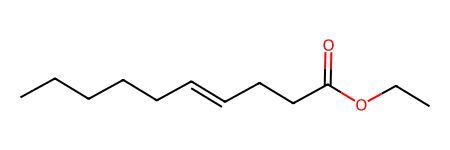


##################
Example id: 173
GT smiles: CCOC(O)CCCCCC(C)CC


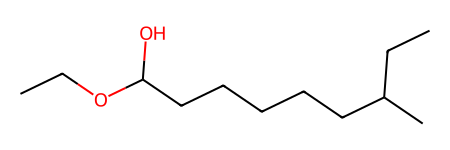

Best DB search candidate: CCCCCC=CCCC(=O)OCC similarity: 0.162790697674418


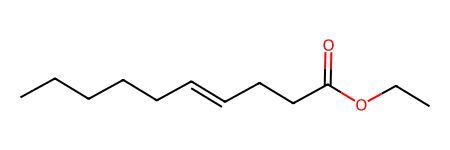

Best prediction: CCCCCC=CCCC(=O)OCC, similarity: 1.0


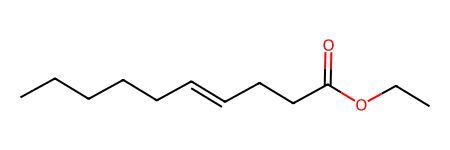


##################
Example id: 174
GT smiles: CCC(C)CCCCCC(O)OC(C)C


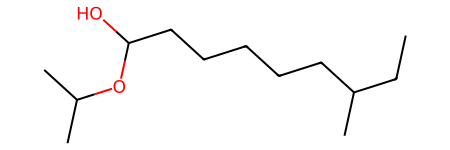

Best DB search candidate: CCc1nc(C)cc(=O)n1C similarity: 0.065217391304347


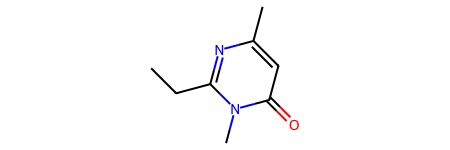

Best prediction: CCCCCCCC=CC(=O)OC(C)C, similarity: 0.05555555555555555


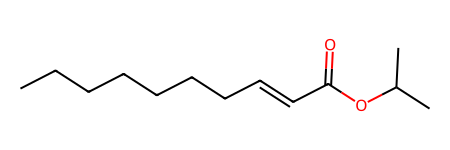


##################
Example id: 175
GT smiles: CCC(C)CCCCCC(O)OC(C)C


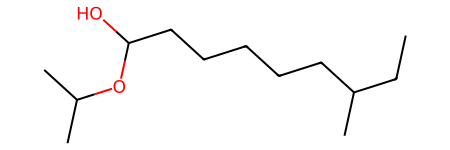

Best DB search candidate: CCc1nc(C)cc(=O)n1C similarity: 0.065217391304347


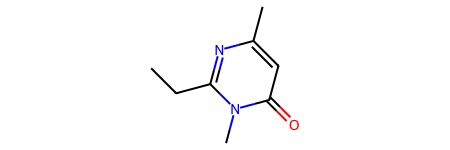

Best prediction: CCCCCCC(C)=CCC(C)C(=O)O, similarity: 0.05283757338551859


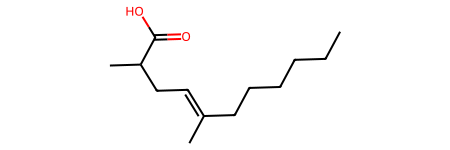


##################
Example id: 176
GT smiles: CCCCCCCCCCCCCCCCCCCCCCC(C)CCCC


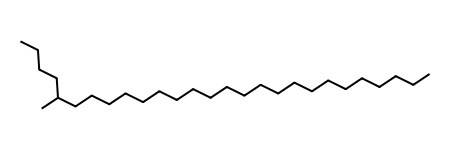

Best DB search candidate: CCCCCCCCCCCCCCCCCCCCCCCCC(C)CCCC similarity: 1.0


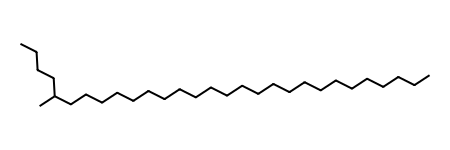

Best prediction: CCCCCCCCCCCCCCCCCCCCCC(C)CC, similarity: 1.0


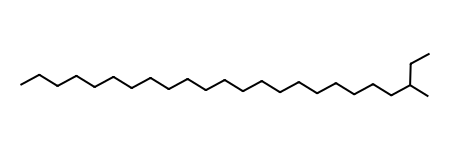


##################
Example id: 177
GT smiles: CCCCCCCCCC(C)O


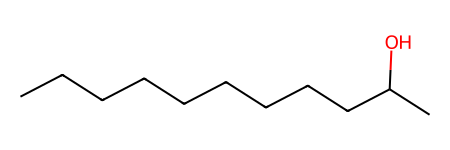

Best DB search candidate: CC1=C(C)C(C(C)(C)CCC=O)CC1 similarity: 0.069767441860465


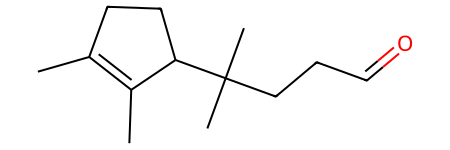

Best prediction: CCC1CCCC2(C)CCC=C12, similarity: 0.528957528957529


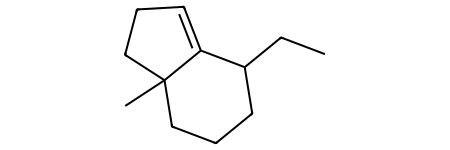


##################
Example id: 178
GT smiles: CC1CC(OC(C)O)CC(C)(C)C1


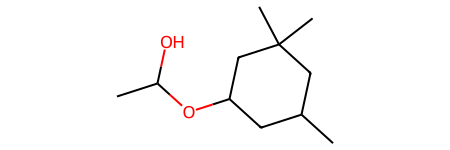

Best DB search candidate: C#CC#C[Si](C)(C)C similarity: 0.025641025641025002


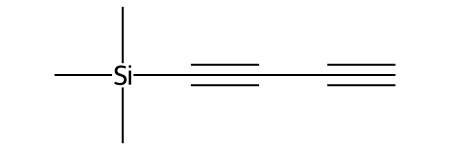

Best prediction: CC1=C(C)C(C)(CO)CC1, similarity: 0.024489795918367346


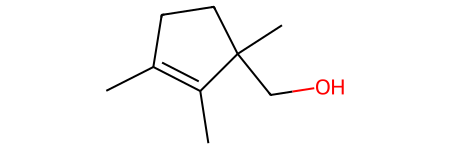


##################
Example id: 179
GT smiles: CCCCC(CC)C(O)CCC


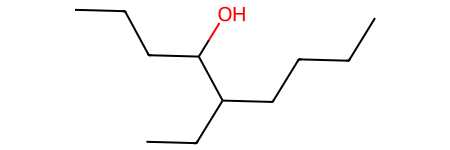

Best DB search candidate: CCCC(C)C(=O)C(C)CC similarity: 0.30000000000000004


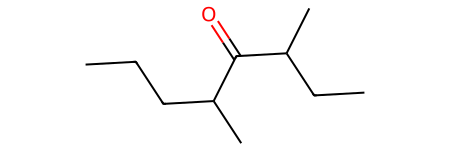

Best prediction: CCCCCC(C)CC(C)CC, similarity: 0.4657534246575342


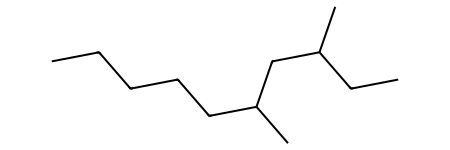


##################
Example id: 180
GT smiles: CCCCCCC(CC)C(C)O


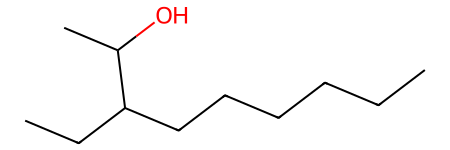

Best DB search candidate: CCCCCCCCC(CC)C(C)=O similarity: 0.433333333333333


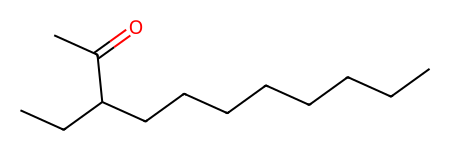

Best prediction: CCCCCCC(CC)C(C)=O, similarity: 1.0


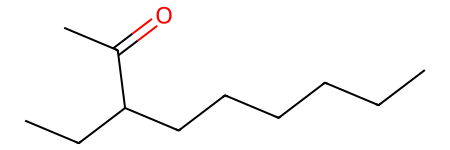


##################
Example id: 181
GT smiles: CCCCCCCCCCC(CC)CO


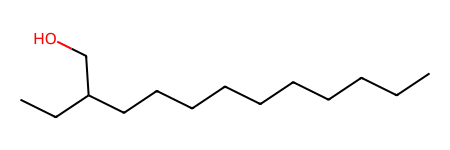

Best DB search candidate: CC1(C)C(O)C(C)(C)C1O similarity: 0.07142857142857101


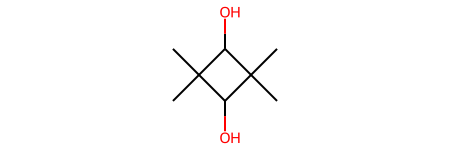

Best prediction: CCCCCCCCCCC(O)C(C)(C)C, similarity: 0.36923076923076925


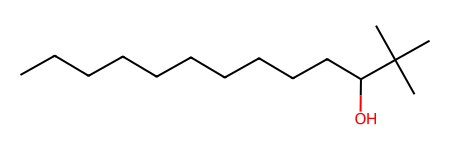


##################
Example id: 182
GT smiles: CCCC(O)CC(O)C(CC)CC


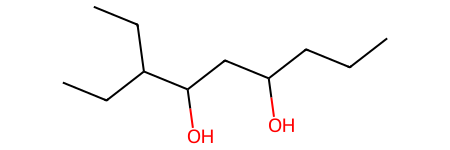

Best DB search candidate: CCCC(=O)CC(=O)C(CC)CC similarity: 0.24242424242424201


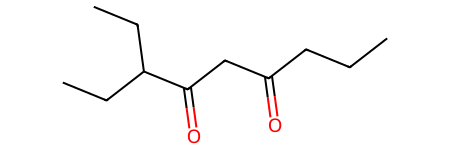

Best prediction: CCC(CC)C(=O)CC(=O)C(C)C, similarity: 1.0


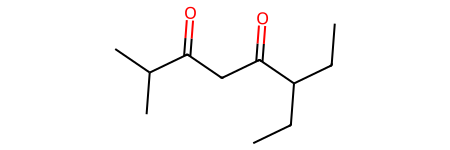


##################
Example id: 183
GT smiles: COC(O)C(COC(O)C(C)C)NC(O)CCC(C)C


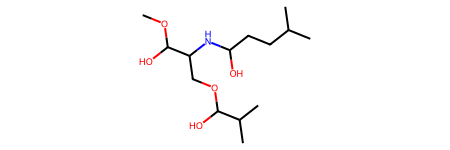

Best DB search candidate: CCCCCC(=O)NC(COC(=O)CCCCC)C(=O)OC similarity: 0.16666666666666602


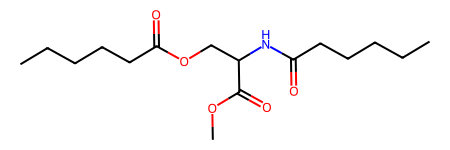

Best prediction: CCCCCC(=O)NC(COC(=O)CCCCC)C(=O)OC, similarity: 1.0


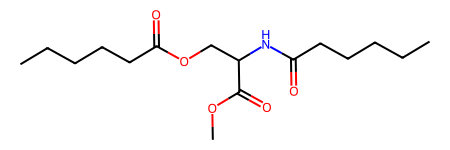


##################
Example id: 189
GT smiles: CCCC(O)OCC(NC(O)CCC(C)C)C(O)OC


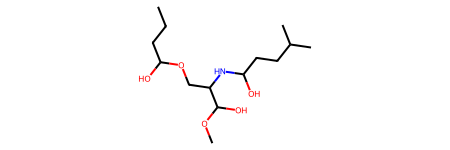

Best DB search candidate: CCCCCC(=O)NC(COC(=O)CCCCC)C(=O)OC similarity: 0.2


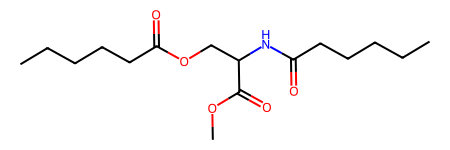

Best prediction: CCCCCC(=O)NC(COC(=O)CCCCC)C(=O)OC, similarity: 1.0


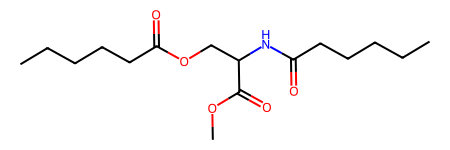


##################
Example id: 184
GT smiles: CC1CCC2C(C1)C(C(C)C)CCC2(C)O


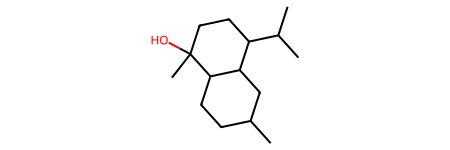

Best DB search candidate: CC1=CC2C(C(C)C)CCC(C)(O)C2CC1 similarity: 0.43181818181818105


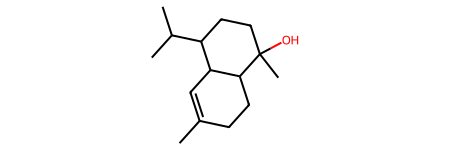

Best prediction: CC1=CC2C(C(C)C)CCC(C)(O)C2CC1, similarity: 1.0


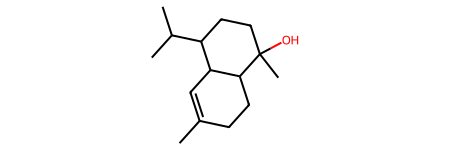


##################
Example id: 185
GT smiles: CC1CCC2C(C1)C(C(C)C)CCC2(C)O


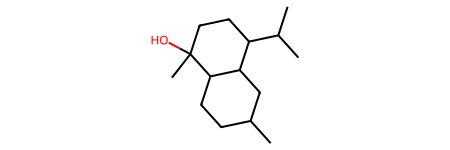

Best DB search candidate: CC1=CC2C(C(C)C)CCC(C)(O)C2CC1 similarity: 0.43181818181818105


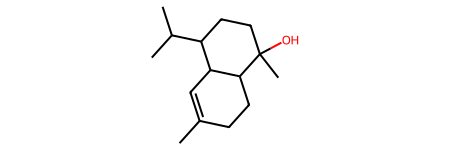

Best prediction: CC1=CC2C(C(C)C)CCC(C)(O)C2CC1, similarity: 1.0


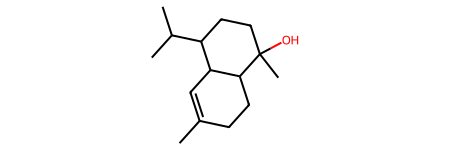


##################
Example id: 186
GT smiles: CC1CCC2C(C1)C(C(C)C)CCC2(C)O


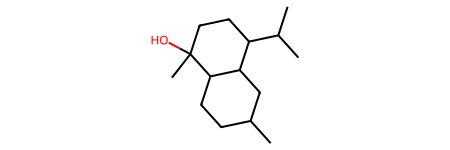

Best DB search candidate: CC1=CC2C(C(C)C)CCC(C)(O)C2CC1 similarity: 0.43181818181818105


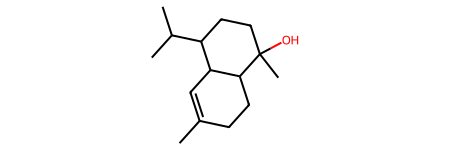

Best prediction: CC1=CC2C(C(C)C)CCC(C)(O)C2CC1, similarity: 1.0


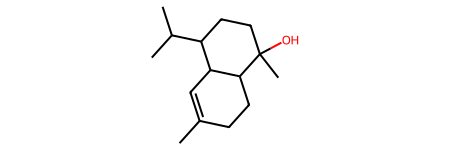


##################
Example id: 187
GT smiles: CC1CCC2C(C1)C(C(C)C)CCC2(C)O


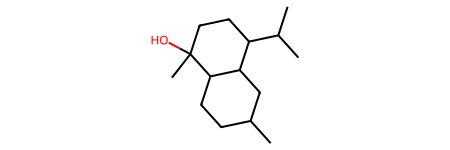

Best DB search candidate: CC1=CC2C(C(C)C)CCC(C)(O)C2CC1 similarity: 0.43181818181818105


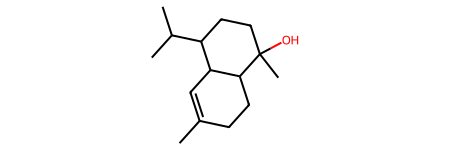

Best prediction: CC1=CC2C(C(C)C)CCC(C)(O)C2CC1, similarity: 1.0


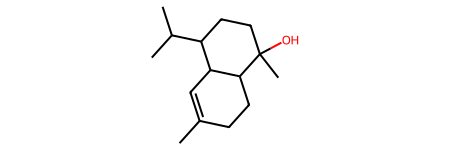


##################
Example id: 188
GT smiles: CC1CCC2C(C1)C(C(C)C)CCC2(C)O


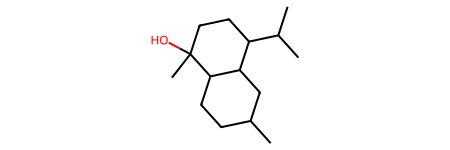

Best DB search candidate: CC1=CC2C(C(C)C)CCC(C)(O)C2CC1 similarity: 0.43181818181818105


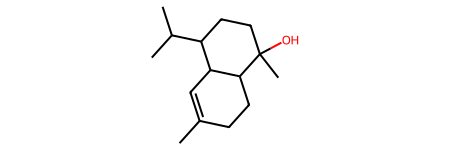

Best prediction: CC1=CC2C(C(C)C)CCC(C)(O)C2CC1, similarity: 1.0


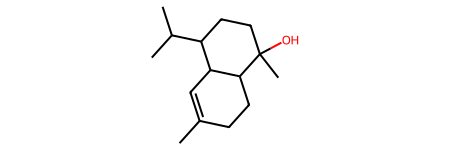


##################
Example id: 190
GT smiles: CCCC(CCOC(O)C(C)C)OC(O)C(C)C


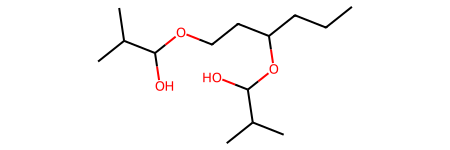

Best DB search candidate: CCCC(OC(=O)C(C)C)C(CC)CO similarity: 0.22727272727272702


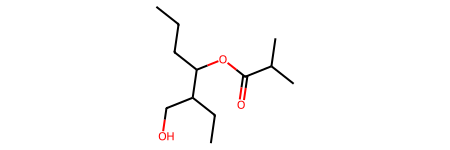

Best prediction: CCCC(=O)OCCC(CC)OC(=O)C(C)C, similarity: 0.5850622406639004


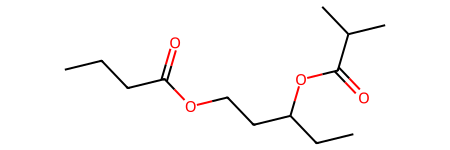


##################
Example id: 191
GT smiles: CC1CCCC(C)CC(O)OCC2(C)OC2CC1


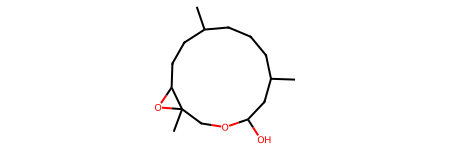

Best DB search candidate: CC(C)=CCCC(C)C1=CCC(O)C1(C)C similarity: 0.12068965517241301


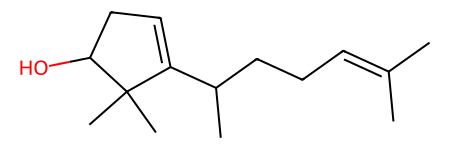

Best prediction: C=C1CCCC2(C)OC(=O)C(C(C)C)CC12C, similarity: 0.35584843492586493


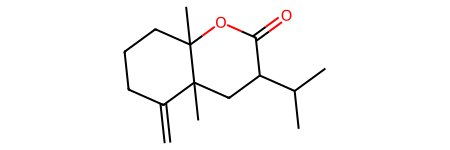


##################
Example id: 192
GT smiles: CC(C)CCCC1CCN2CCCC2C1


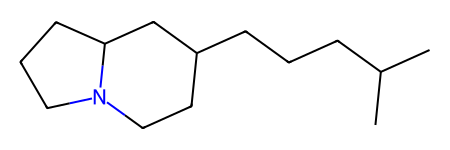

Best DB search candidate: CC1=CC2C3C=CC(C)(C(=O)C3(C)C)C2C(C)(C)C1=O similarity: 0.032786885245901


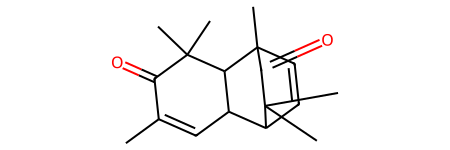

Best prediction: CC(C)=CCC1C(C)=CCN2CCCC12, similarity: 0.2549618320610687


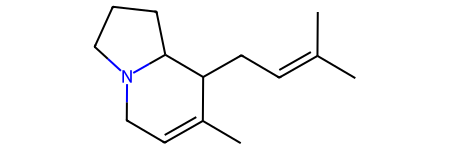


##################
Example id: 193
GT smiles: CCCC(C)C(O)NCCC1CCC(O)CC1


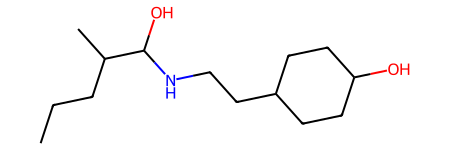

Best DB search candidate: CC1(C)CCCC(C)(C)N1OC(=O)c1ccc(N)cc1 similarity: 0.04918032786885201


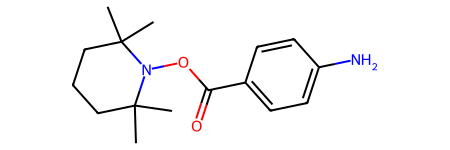

Best prediction: O=C(CCC1CCCC1)Nc1ccc(CCO)cc1, similarity: 0.21474358974358973


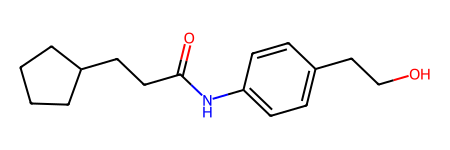


##################
Example id: 194
GT smiles: CC1CCCC(C)CCC2(C)CCC(C(C)(C)O)C2CC1


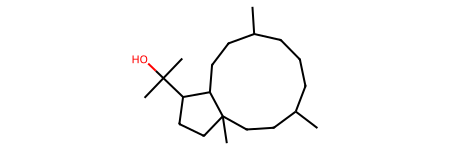

Best DB search candidate: CC1=CCCC(C)=CCC(O)(C(C)C)CCC(C)=CCC1 similarity: 0.115384615384615


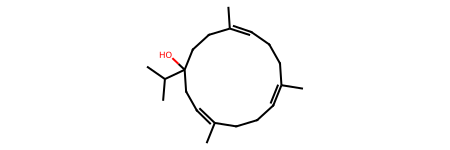

Best prediction: C=C1CCC=C(C)CCC(O)(C(C)C)CC=C(C)CCC1, similarity: 0.9304347826086956


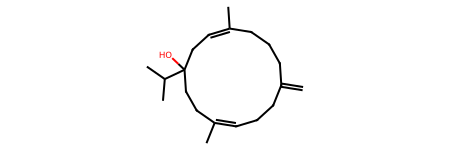


##################
Example id: 195
GT smiles: CCC1CC2CCC(C)C(C)(O1)O2


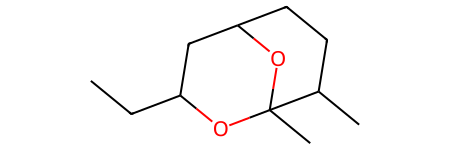

Best DB search candidate: CC(=O)Cc1ccc(F)cc1 similarity: 0.043478260869565


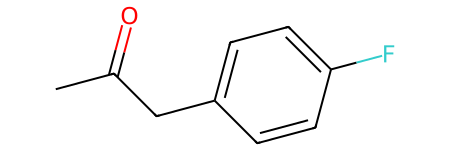

Best prediction: CC(=O)C1CCC(C)C2OC2C1=O, similarity: 0.08061002178649238


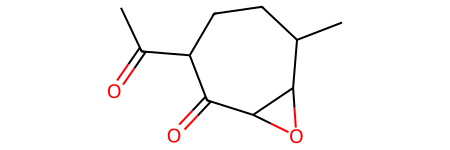


##################
Example id: 196
GT smiles: CCC(O)C(O)NCCC1CCC(O)CC1


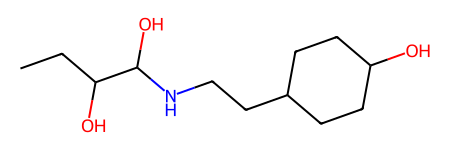

Best DB search candidate: CC(=O)O.CC(=O)Oc1ccc(CCO)cc1 similarity: 0.056603773584905


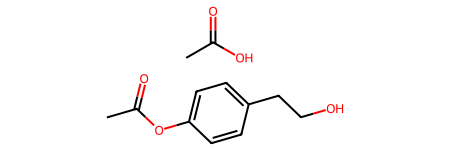

Best prediction: CCCCCC(=O)Oc1ccc(CCC)cc1, similarity: 0.6484641638225256


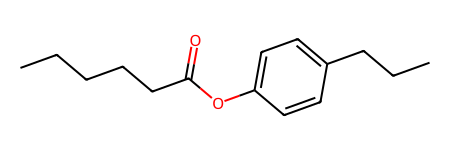


##################
Example id: 198
GT smiles: CCC(O)C(O)NCCC1CCC(O)CC1


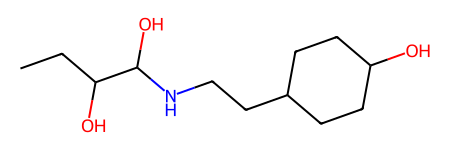

Best DB search candidate: CC(=O)O.CC(=O)Oc1ccc(CCO)cc1 similarity: 0.056603773584905


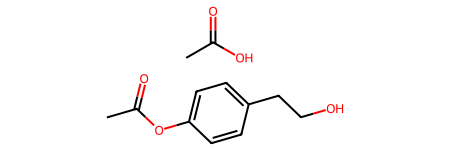

Best prediction: COC(=O)C(C)(C)OCCc1ccc(O)cc1, similarity: 0.4161849710982659


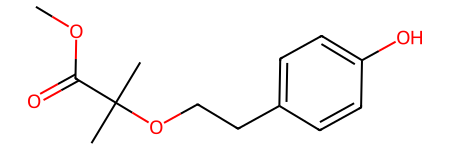


##################
Example id: 197
GT smiles: CCCC(C)C(O)NCCC1CCC(O)CC1


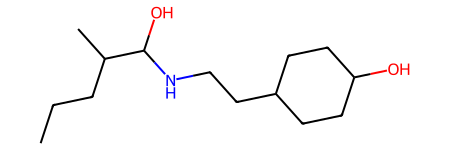

Best DB search candidate: CC(=O)NCCc1ccc(O)cc1 similarity: 0.096153846153846


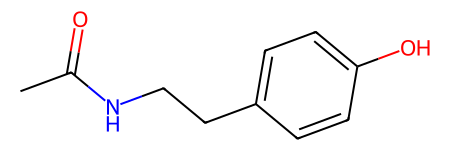

Best prediction: CCC(=O)CCCCCCc1ccc(O)cc1, similarity: 0.44


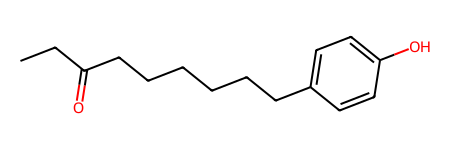


##################
Example id: 199
GT smiles: CCCCCCCC1CCC2CCC(C)N12


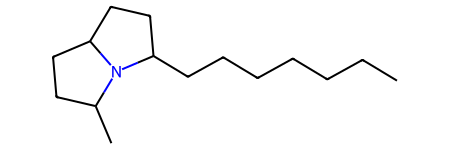

Best DB search candidate: CCCCCCCC1CCC2CCC(C)N12 similarity: 1.0


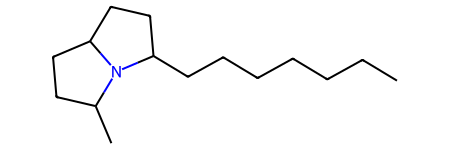

Best prediction: CCCCCCC1CCC2CCC(C)N12, similarity: 1.0


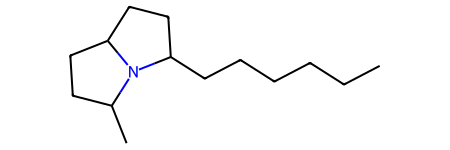


##################
Example id: 200
GT smiles: CCCCCCC1CCC2CCC(CCCC)N12


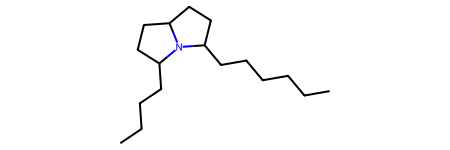

Best DB search candidate: CCCCCCC1CCC2CCC(CCCC)N12 similarity: 1.0


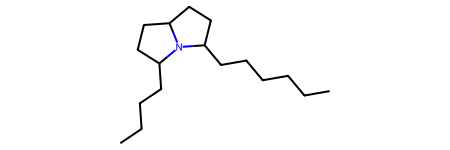

Best prediction: CCCCCCC1CCC2CCC(CCC)N12, similarity: 1.0


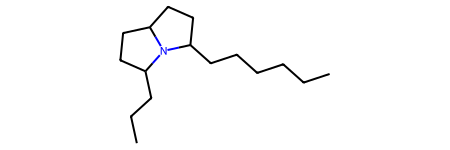


##################
Example id: 201
GT smiles: CCC(O)C(O)NCCC1CCC(O)CC1


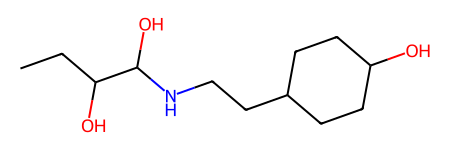

Best DB search candidate: C=Cc1ccc(OC(C)(C)C)cc1 similarity: 0.0625


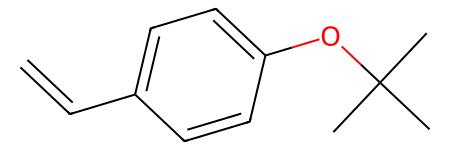

Best prediction: CCC(C)C(=O)NCCc1ccc(OC(C)C)cc1, similarity: 0.4349112426035503


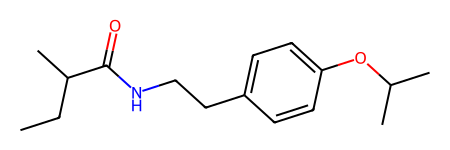


##################
Example id: 202
GT smiles: CCCCCCC1CCC(CCCCCCCC(C)O)N1


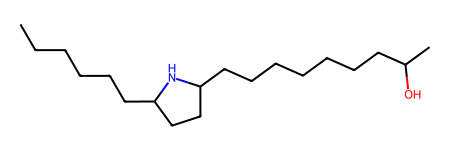

Best DB search candidate: CN1C(=O)CCC2(CCC(=O)NC2)C1=O similarity: 0.055555555555555004


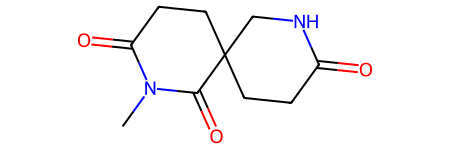

Best prediction: CCCCCCC1CCC(CCCCCC)N1C(C)=O, similarity: 0.24358974358974358


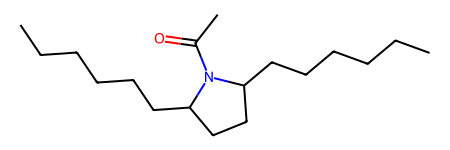


##################
Example id: 203
GT smiles: CC1(C)CCC2C(CCN3CCCC23)C1


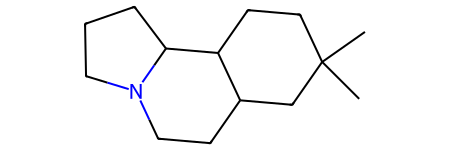

Best DB search candidate: CCCCCCCCCCCCCCCCOC(=O)c1cc(F)c(F)c(OC)c1F similarity: 0.03125


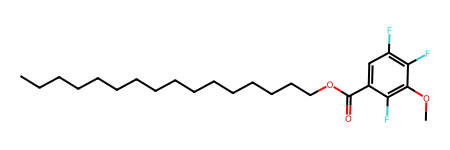

Best prediction: CC1CC2CCCN2C2CCCCN2C1, similarity: 0.12417582417582418


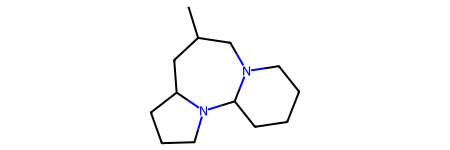

In [30]:
# visualize comparison

range_to_viz = (100, 201)

for i, row in df_labels_filtered_overlapped.iloc[min(range_to_viz):max(range_to_viz)].iterrows():
    print("\n##################")
    print(f"Example id: {i}")
    print("GT smiles:", row["smiles"])
    gt_mol = Chem.MolFromSmiles(row["smiles"])
    display(gt_mol)

    print("Best DB search candidate:", row["smiles_ref"], "similarity:", row["smiles_sim_of_closest_morgan_tanimoto"])
    db_mol = Chem.MolFromSmiles(row["smiles_ref"])
    display(db_mol)

    print(f"Best prediction: {row['best_prediction']}, similarity: {row['best_prediction_simil']}")
    pred_mol = Chem.MolFromSmiles(row["best_prediction"])
    display(pred_mol)


In [22]:
df_labels_filtered_overlapped

,mz,intensity,smiles,index_of_closest,spectra_sim_of_closest,smiles_sim_of_closest_morgan_tanimoto,predictions,mz_ref,intensity_ref,smiles_ref,best_prediction,best_prediction_simil
4,"[39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 51.0, 53....","[19.0, 6.0, 202.0, 62.0, 539.0, 20.0, 1.0, 10....",CCCCCCCCCCCCCCCCC(C)CCCC(C)CCCCCCCCCC,231478,0.990189,0.500000,"[CCCCCCCCCCCCCCC(C)CCCC(C)CCCCCCCCCCC, CCCCCCC...","[26.0, 27.0, 28.0, 29.0, 30.0, 38.0, 39.0, 40....","[2.0, 20.98, 6.99, 77.93, 2.0, 1.0, 13.99, 4.0...",CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC,CCCCCCCCCCCCCCC(C)CCCC(C)CCCCCCCCCCC,0.466667
16,"[33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40....","[4.0, 1.0, 8.0, 24.0, 37.0, 76.0, 331.0, 77.0,...",OCC1CCN2CCC(O)C12,135540,0.811332,0.116279,"[Nc1c(O)ccc2c1CCO2, Nc1cccc(CO)c(=O)c1, Nc1ccc...","[27.0, 29.0, 30.0, 31.0, 33.0, 37.0, 38.0, 39....","[14.99, 90.92, 42.96, 15.99, 10.99, 19.98, 38....",O=CC=C1CCC2CCCN12,Nc1cccc2c1CCC2O,0.104265
34,"[50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57....","[2.0, 5.0, 6.0, 47.0, 78.0, 332.0, 56.0, 232.0...",CCCCCCCCCCCCCCCCCCCCCCCCC,85978,0.932121,0.156250,"[C=CCC=CCC=CCCCCCCCCCCCCCCCC, C=CCC=CCC=CCCCCC...","[51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 59....","[9.99, 9.99, 69.94, 99.91, 448.6, 19.98, 59.95...",CCC=CCC=CCC=CCCCCCCCCCC(=O)OC,CCC=CCC=CCC=CCCCCCCCCCCCCCCO,0.589286
35,"[38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 50....","[1.0, 56.0, 10.0, 351.0, 31.0, 261.0, 8.0, 1.0...",CCCCCCCCCCCCCCCCCCCCC,95239,0.966313,0.172414,"[C=CCC=CCC=CCC=CCCCCCCCCCC, C=CCC=CCC=CCCCCCCC...","[15.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 37....","[1.0, 3.0, 43.96, 11.99, 71.94, 2.0, 5.0, 1.0,...",CCC=CCC=CCC=CCCCCCCCCCC(=O)O,C=CCC=CCC=CCC=CCCCCCCCCCC,0.565217
36,"[36.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45....","[1.0, 76.0, 73.0, 413.0, 36.0, 271.0, 12.0, 1....",CCCCCCCCCCCCCCCCCCCCC,21852,0.954775,0.269231,"[C=CC=CCC=CCC=CCCCCCCCCCCC, C=CCC1CC=CC(C=CCC=...","[15.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 36....","[1.0, 2.0, 52.95, 8.99, 108.9, 3.0, 3.0, 1.0, ...",CCCCCC=CCC=CCC=CCC=CCCCC(=O)O,C=CCC=CCC=CCC=CCCCCCCCCCC,0.505495
42,"[37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44....","[5.0, 11.0, 172.0, 40.0, 262.0, 232.0, 999.0, ...",CCCCCC(O)CCO,69216,0.841376,0.129032,"[CCC(C)(C(C)=O)C(=O)O, CCCC(=O)C(C)C(=O)O, CCC...","[15.0, 19.0, 26.0, 27.0, 28.0, 29.0, 31.0, 37....","[4.0, 1.0, 5.0, 95.91, 12.99, 52.95, 10.99, 4....",CC(C)C(C)CC(=O)O,CCCC(C)C(=O)OCC,0.368421
52,"[51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58....","[7.0, 9.0, 68.0, 328.0, 508.0, 68.0, 174.0, 9....",CCCCCCCCCCCCCCCCCCCCC,127180,0.954695,0.363636,"[C=CCCCC=CCCCCCCCCCCCCCC, C=CCCCCC=CCCCCCCCCCC...","[14.0, 15.0, 18.0, 26.0, 27.0, 28.0, 29.0, 30....","[1.0, 8.99, 2.0, 3.0, 33.97, 42.96, 86.92, 2.0...",CCCCCC=CCC=CCCCCCCCCO,CCCCCC=CCC=CCCCCCCCCCCC,0.781250
53,"[51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58....","[9.0, 7.0, 59.0, 78.0, 278.0, 32.0, 147.0, 8.0...",CCCCCCCCCCCCCCCCCCCCC,167782,0.960562,0.138889,"[C=CC=CCC=CCC=CCCCCCCCCCCC, C=CC=CCC=CCCCCCCCC...","[51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58....","[19.98, 9.99, 99.91, 89.92, 398.64, 29.97, 108...",CCC=CCC=CCC=CCCCCCCC(O)C(=O)OC,C=CCC=CCC=CCC=CCCCCCCCCCC,0.331210
54,"[51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58....","[25.0, 21.0, 70.0, 75.0, 257.0, 38.0, 217.0, 1...",CCCCCCCCCCCCCCCCCCCCC,43516,0.956555,0.269231,"[C=CC1CC=CCC=CCC=CCCCCCCCCO1, C=CC=CCC=CCC=CCC...","[43.0, 44.0, 45.0, 50.0, 51.0, 52.0, 53.0, 54....","[141.87, 6.99, 29.97, 3.0, 20.98, 12.99, 89.92...",CCCCCC=CCC=CCC=CCC=CCCCC(=O)O,C=CCC=CCC=CCC=CCC=CCCCCCCC,0.505495
56,"[51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58....","[13.0, 12.0, 73.0, 184.0, 420.0, 44.0, 397.0, ...",CCCCCCCCCCCCCCCCCCCCC,163029,0.903804,0.275862,"[C=CCC=CCC=CCC=CCCCCCCCCCC, C=CCC=CCC=CCCCCCCC...","[51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58....","[19.98, 19.98, 138.87, 158.86, 488.56, 59.95, ...",CCCCCCCCCCC=CCC=CCCC(=O)OC,CCCCCCCCC=CCC=CCCCCCCCC,0.454545
